<a href="https://colab.research.google.com/github/leenamemon/SeniorThesis/blob/main/ThesisAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantitative Metrics for **Regional Indices**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import os
import re
import matplotlib
import cvxpy as cp

In [ ]:
# Mount Google Drive (if needed)
from google.colab import drive
drive.mount('/content/drive')

# Specify the folder path
folder_path = '/content/drive/My Drive/Thesis/Indices'
os.listdir(folder_path)

# List all files in the folder
file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.xlsx')]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def extract_first_last_dates(file_paths):
    results = []

    for file_path in file_paths:
        print(f"Processing file: {file_path}")  # Debug

        # Load the Excel file
        df = pd.read_excel(file_path)

        # Identify the date column (assume first column if not labeled)
        date_column = next((col for col in df.columns if 'date' in col.lower()), df.columns[0])
        df[date_column] = pd.to_datetime(df[date_column], format='%m/%d/%Y', errors='coerce')

        # Handle invalid dates
        df.dropna(subset=[date_column], inplace=True)

        if not df.empty:
            first_date = df[date_column].min().strftime('%Y-%m-%d')
            last_date = df[date_column].max().strftime('%Y-%m-%d')
            results.append([os.path.basename(file_path), first_date, last_date])

    # Create a DataFrame with results
    results_df = pd.DataFrame(results, columns=['File Name', 'First Date', 'Last Date'])
    results_df.sort_values(by=['File Name'], inplace=True)
    return results_df

# Run the function and display the table
date_summary = extract_first_last_dates(file_paths)

Processing file: /content/drive/My Drive/Thesis/Indices/BDDSESD.xlsx
Processing file: /content/drive/My Drive/Thesis/Indices/DJIAP.xlsx
Processing file: /content/drive/My Drive/Thesis/Indices/DJICHK.xlsx
Processing file: /content/drive/My Drive/Thesis/Indices/DJIM.xlsx
Processing file: /content/drive/My Drive/Thesis/Indices/DSES.xlsx
Processing file: /content/drive/My Drive/Thesis/Indices/SHE.xlsx
Processing file: /content/drive/My Drive/Thesis/Indices/SDEURS.xlsx
Processing file: /content/drive/My Drive/Thesis/Indices/SGS100.xlsx
Processing file: /content/drive/My Drive/Thesis/Indices/FTWORLD.xlsx
Processing file: /content/drive/My Drive/Thesis/Indices/IMUS.xlsx
Processing file: /content/drive/My Drive/Thesis/Indices/IMXL.xlsx
Processing file: /content/drive/My Drive/Thesis/Indices/JKII.xlsx
Processing file: /content/drive/My Drive/Thesis/Indices/JPNU.xlsx
Processing file: /content/drive/My Drive/Thesis/Indices/SWDPAC.xlsx
Processing file: /content/drive/My Drive/Thesis/Indices/SWDPAC

In [ ]:
def extract_first_last_dates(file_paths):
    results = []

    for file_path in file_paths:

        # Load the Excel file
        df = pd.read_excel(file_path)

        # Identify the date column (assume first column if not labeled)
        date_column = next((col for col in df.columns if 'date' in col.lower()), df.columns[0])
        df[date_column] = pd.to_datetime(df[date_column], format='%m/%d/%Y', errors='coerce')

        # Handle invalid dates
        df.dropna(subset=[date_column], inplace=True)

        if not df.empty:
            first_date = df[date_column].min().strftime('%Y-%m-%d')
            last_date = df[date_column].max().strftime('%Y-%m-%d')
            results.append([os.path.basename(file_path), first_date, last_date])

    # Create a DataFrame with results
    results_df = pd.DataFrame(results, columns=['File Name', 'First Date', 'Last Date'])
    results_df.sort_values(by=['File Name'], inplace=True)
    return results_df

# Run the function and display the table
date_summary = extract_first_last_dates(file_paths)

In [ ]:
def calculate_annual_metrics(file_paths):
    annual_returns = {}
    annual_vol = {}
    annual_var = {}
    annual_cvar = {}

    start_year = 2015
    end_year = 2024

    for file_path in file_paths:
        # Load the Excel file
        df = pd.read_excel(file_path)

        # Extract file name without extension
        file_name = os.path.splitext(os.path.basename(file_path))[0]

        # Convert the first column to datetime, handling errors
        date_column = df.columns[0]
        df[date_column] = pd.to_datetime(df[date_column], format='%m/%d/%Y', errors='coerce')

        # Ensure the second column (closing prices) is numeric
        price_column = df.columns[1]
        df[price_column] = pd.to_numeric(df[price_column], errors='coerce')

        # Drop rows with NaN values in either column
        df.dropna(subset=[date_column, price_column], inplace=True)

        # Sort by date in case the data isn't ordered
        df.sort_values(by=date_column, inplace=True)

        # Calculate daily returns
        df['Returns'] = df[price_column].pct_change()

        # Initialize lists for storing yearly metrics
        yearly_returns = []
        yearly_vol = []
        yearly_var = []
        yearly_cvar = []

        for year in range(start_year, end_year + 1):
            yearly_data = df[df[date_column].dt.year == year]['Returns'].dropna()

            if not yearly_data.empty:
                # Annual Return
                yearly_returns.append((yearly_data + 1).prod() - 1)

                # Annual Volatility (Standard deviation of daily returns scaled to annual)
                yearly_vol.append(yearly_data.std() * np.sqrt(252))

                # Value at Risk (VaR) at 95% confidence level
                var_95 = yearly_data.quantile(0.05)
                yearly_var.append(var_95)

                # Conditional Value at Risk (CVaR) - Expected Shortfall at 95%
                cvar_95 = yearly_data[yearly_data <= var_95].mean()
                yearly_cvar.append(cvar_95)
            else:
                yearly_returns.append(None)
                yearly_vol.append(None)
                yearly_var.append(None)
                yearly_cvar.append(None)

        # Store the results
        annual_returns[file_name] = yearly_returns
        annual_vol[file_name] = yearly_vol
        annual_var[file_name] = yearly_var
        annual_cvar[file_name] = yearly_cvar

    # Sort results alphabetically by file_name
    annual_returns = dict(sorted(annual_returns.items()))
    annual_vol = dict(sorted(annual_vol.items()))
    annual_var = dict(sorted(annual_var.items()))
    annual_cvar = dict(sorted(annual_cvar.items()))

    return annual_returns, annual_vol, annual_var, annual_cvar

In [ ]:
# Calculate metrics
annual_returns, annual_vol, annual_var, annual_cvar = calculate_annual_metrics(file_paths)

# **Regional Index Heatmaps**

In [ ]:
def plot_annual_returns_heatmap(annual_returns):
    # Convert the dictionary to a DataFrame
    years = list(range(2015, 2025))
    annual_returns_df = pd.DataFrame(annual_returns, index=years)

    # Rename specific indices and move them to the front
    rename_dict = {"FTWORLD": "FTSE (Con.)", "SPX": "SPX (Con.)", "W1DOW": "DOW (Con.)"}
    annual_returns_df = annual_returns_df.rename(columns=rename_dict)
    column_order = [col for col in rename_dict.values() if col in annual_returns_df.columns] + [col for col in annual_returns_df.columns if col not in rename_dict.values()]
    annual_returns_df = annual_returns_df[column_order]

    # Apply rounding rules
    annual_returns_df = annual_returns_df.map(lambda x: round(x, 1) if abs(x) < 0.01 else round(x, 3))
    # annual_returns_df = annual_returns_df.map(lambda x: 0 if abs(x) < 0.001 else x)

    # Plotting the heatmap
    plt.figure(figsize=(25, 6))
    sns.heatmap(annual_returns_df, annot=True, cmap="RdYlGn", center=0)
    plt.xlabel('Indices')
    plt.ylabel('Year')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Show the plot
    plt.show()

In [ ]:
def plot_annual_vol_heatmap(annual_vol):
    # Convert the dictionary to a DataFrame
    years = list(range(2015, 2025))
    annual_vol_df = pd.DataFrame(annual_vol, index=years)

    # Rename specific indices and move them to the front
    rename_dict = {"FTWORLD": "FTSE (Con.)", "SPX": "SPX (Con.)", "W1DOW": "DOW (Con.)"}
    annual_vol_df = annual_vol_df.rename(columns=rename_dict)
    column_order = [col for col in rename_dict.values() if col in annual_vol_df.columns] + [col for col in annual_vol_df.columns if col not in rename_dict.values()]
    annual_vol_df = annual_vol_df[column_order]

    # Apply rounding rules
    annual_vol_df = annual_vol_df.map(lambda x: round(x, 1) if abs(x) < 0.01 else round(x, 3))
    # annual_vol_df = annual_vol_df.map(lambda x: 0 if abs(x) < 0.001 else x)

    # Plotting the heatmap
    plt.figure(figsize=(25, 6))
    sns.heatmap(annual_vol_df, annot=True, cmap="coolwarm", vmin=0, vmax=0.4)
    plt.xlabel('Indices')
    plt.ylabel('Year')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Show the plot
    plt.show()

In [ ]:
def plot_annual_cvar_heatmap(annual_cvar):
    # Convert the dictionary to a DataFrame
    years = list(range(2015, 2025))
    annual_cvar_df = pd.DataFrame(annual_cvar, index=years)

    # Rename specific indices and move them to the front
    rename_dict = {"FTWORLD": "FTSE (Con.)", "SPX": "SPX (Con.)", "W1DOW": "DOW (Con.)"}
    annual_cvar_df = annual_cvar_df.rename(columns=rename_dict)
    column_order = [col for col in rename_dict.values() if col in annual_cvar_df.columns] + [col for col in annual_cvar_df.columns if col not in rename_dict.values()]
    annual_cvar_df = annual_cvar_df[column_order]

    # Apply rounding rules
    annual_cvar_df = annual_cvar_df.map(lambda x: round(x, 1) if abs(x) < 0.01 else round(x, 3))
    # annual_cvar_df = annual_cvar_df.map(lambda x: 0 if abs(x) < 0.001 else x)

    # Plotting the heatmap
    plt.figure(figsize=(25, 6))
    sns.heatmap(annual_cvar_df, annot=True, cmap="coolwarm_r", vmin=-0.055, vmax=0)
    plt.xlabel('Indices')
    plt.ylabel('Year')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Show the plot
    plt.show()

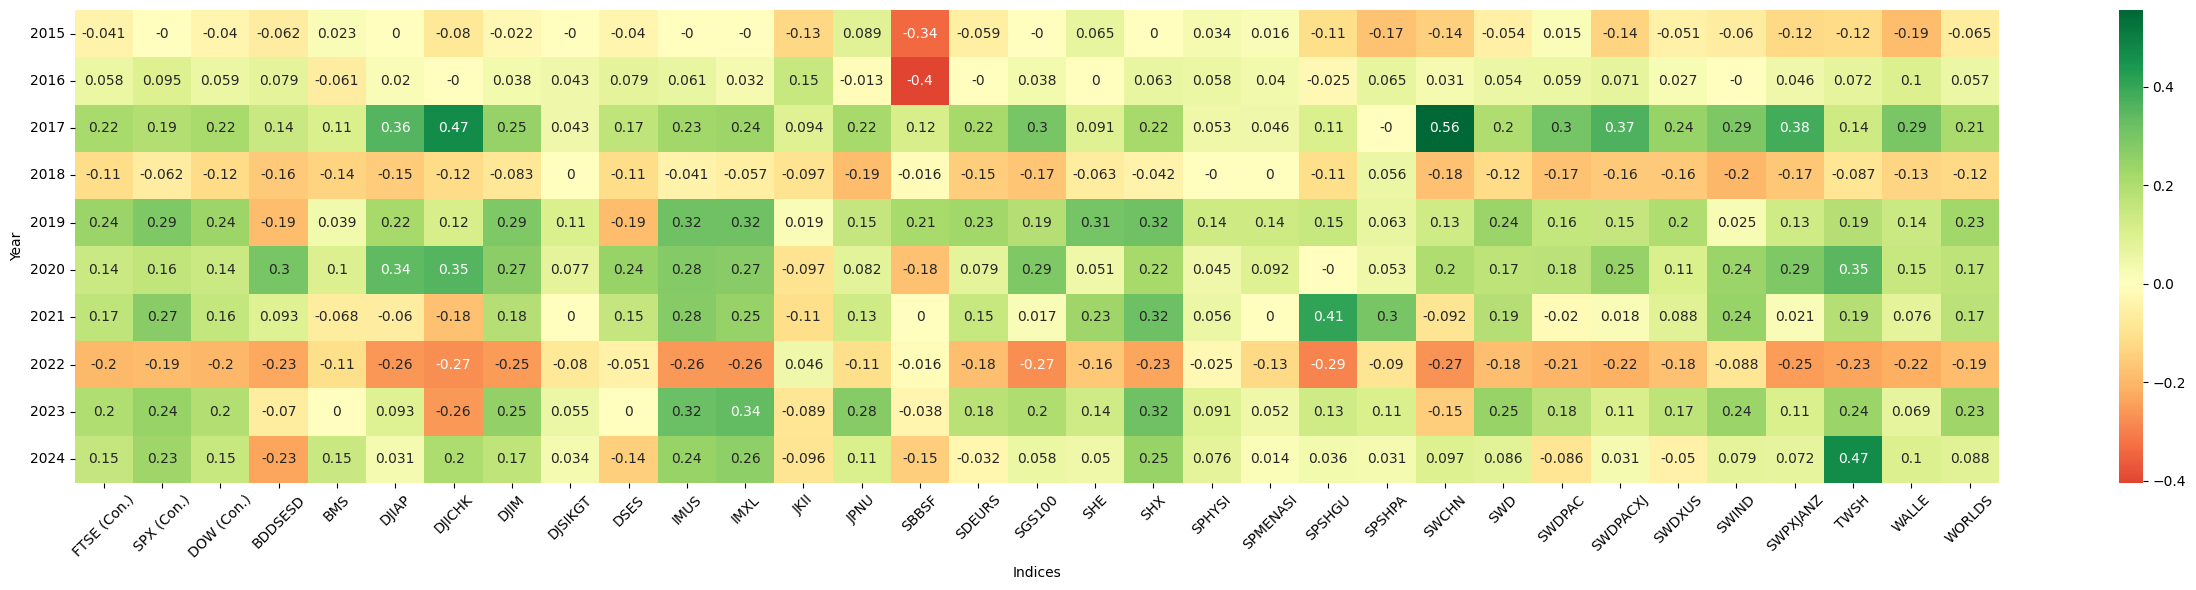

In [ ]:
plot_annual_returns_heatmap(annual_returns)

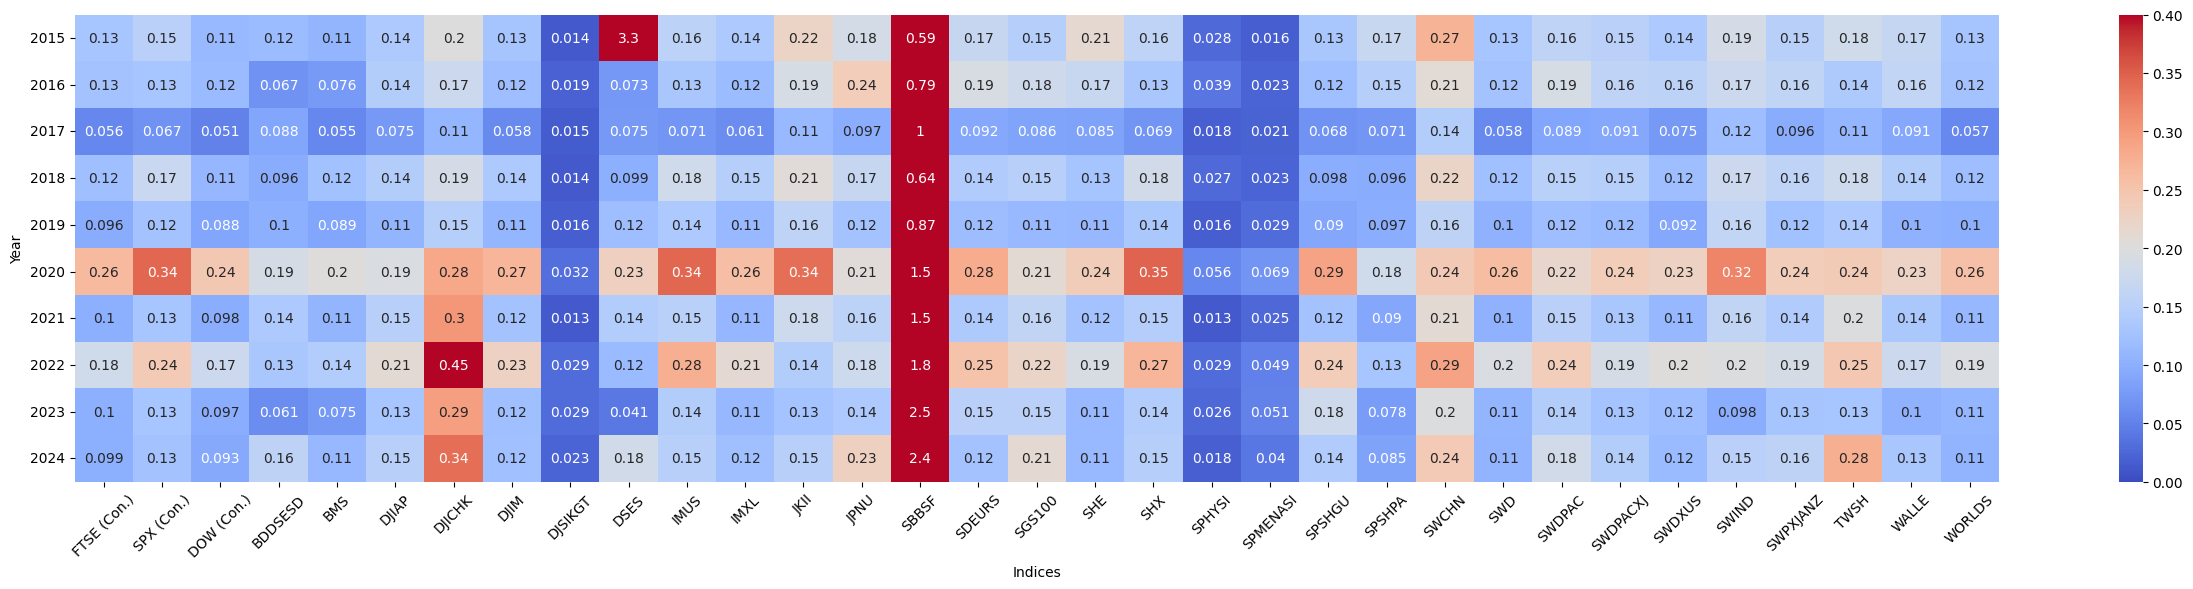

In [ ]:
plot_annual_vol_heatmap(annual_vol)

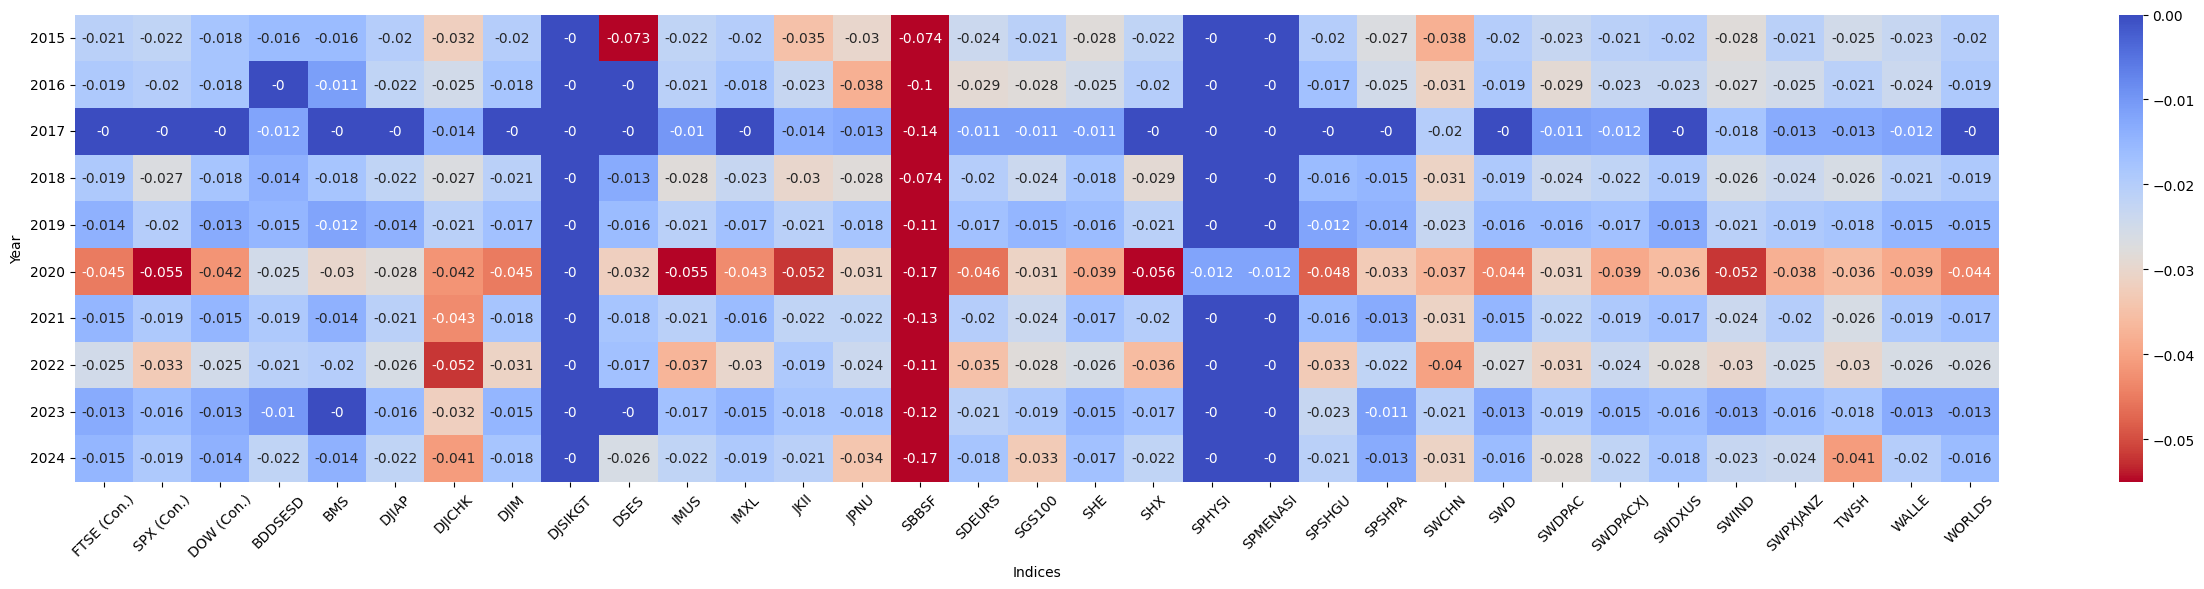

In [ ]:
plot_annual_cvar_heatmap(annual_cvar)

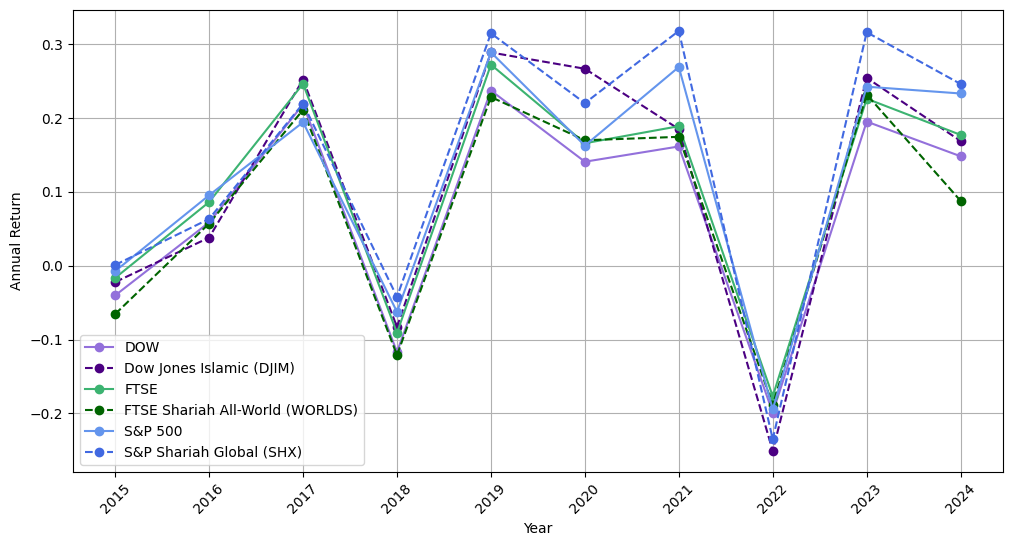

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the new order of indices
ordered_indices = ["W1DOW", "DJIM", "FTWORLD", "WORLDS", "SPX", "SHX"]

# Define custom labels for each index
custom_labels = {
    "W1DOW": "DOW",
    "SPX": "S&P 500",
    "FTWORLD": "FTSE",
    "DJIM": "Dow Jones Islamic (DJIM)",
    "SHX": "S&P Shariah Global (SHX)",
    "WORLDS": "FTSE Shariah All-World (WORLDS)"
}

# Define custom colors and linestyles separately
custom_styles = {
    "W1DOW": {"color": "mediumpurple", "linestyle": "solid"},
    "SPX": {"color": "cornflowerblue", "linestyle": "solid"},
    "FTWORLD": {"color": "mediumseagreen", "linestyle": "solid"},
    "DJIM": {"color": "indigo", "linestyle": "dashed"},
    "SHX": {"color": "royalblue", "linestyle": "dashed"},
    "WORLDS": {"color": "darkgreen", "linestyle": "dashed"}
}

# Convert the dictionary to a DataFrame
years = list(range(2015, 2025))
annual_returns_df = pd.DataFrame(annual_returns, index=years)

# Select and reorder only the required indices
annual_returns_df = annual_returns_df[ordered_indices]

# Plotting the line chart
plt.figure(figsize=(12, 6))

for index in ordered_indices:
    plt.plot(
        years,
        annual_returns_df[index],
        label=custom_labels.get(index, index),
        marker="o",
        linewidth=1.5,
        color=custom_styles[index]["color"],
        linestyle=custom_styles[index]["linestyle"]
    )

plt.xlabel("Year")
plt.ylabel("Annual Return")
plt.xticks(years, [str(year) for year in years], rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# Mean-Variance Optimization for International Indices (Old)

In [ ]:
# Exclude these indices from the portfolio
EXCLUDED_ASSETS = {'W1DOW', 'FTWORLD', 'SPX'}

# Extract valid assets (excluding the specified ones)
valid_assets = [asset for asset in annual_returns.keys() if asset not in EXCLUDED_ASSETS]

# Convert annual return and volatility dictionaries into DataFrames
returns_df = pd.DataFrame(annual_returns, index=range(2015, 2025))[valid_assets]
vol_df = pd.DataFrame(annual_vol, index=range(2015, 2025))[valid_assets]

# Compute mean returns and covariance matrix
mean_returns = returns_df.mean()
cov_matrix = returns_df.cov()

In [ ]:
# Define the optimization function
def optimize_portfolio(max_risk):
    num_assets = len(valid_assets)
    initial_weights = np.ones(num_assets) / num_assets  # Equal weights to start
    bounds = [(0, 1) for _ in range(num_assets)]  # Long-only constraints
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # Sum of weights = 1
        {'type': 'ineq', 'fun': lambda w: max_risk - np.sqrt(w @ cov_matrix @ w)}  # Risk constraint
    ]

    # Objective: Maximize portfolio return
    def neg_sharpe_ratio(w):
        return -np.dot(w, mean_returns)  # We want to maximize return

    result = minimize(neg_sharpe_ratio, initial_weights, bounds=bounds, constraints=constraints)
    return result.x if result.success else None

## Specified Risk

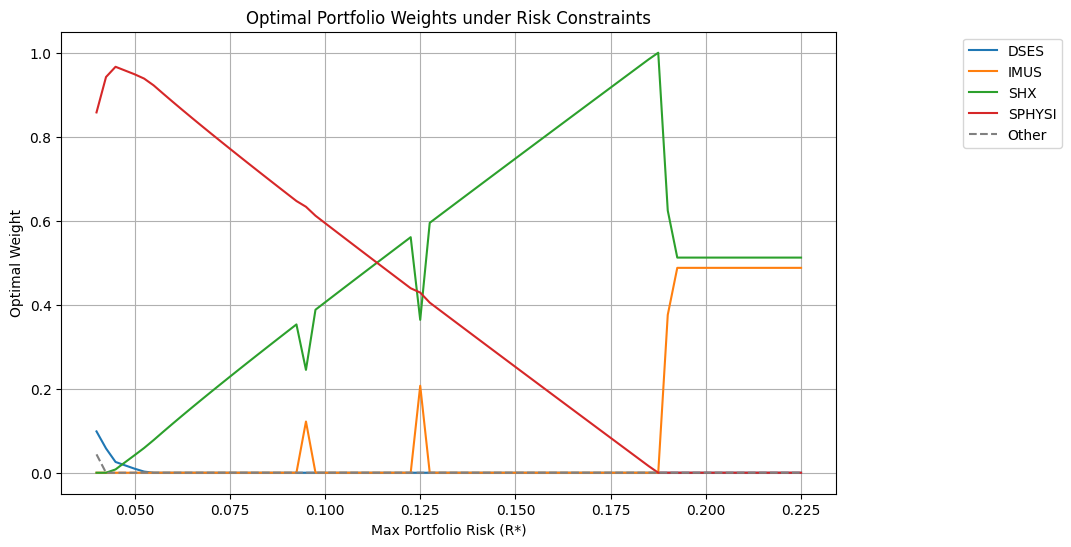

In [ ]:
# Iterate over different max risk values and store results
risk_levels = np.linspace(0, 0.225, 91)
optimal_weights = {asset: [] for asset in valid_assets}

for r_star in risk_levels:
    weights = optimize_portfolio(r_star)
    if weights is not None:
        for i, asset in enumerate(valid_assets):
            optimal_weights[asset].append(weights[i])
    else:
        for asset in valid_assets:
            optimal_weights[asset].append(np.nan)

# Filter relevant indexes (those with nonzero weights at any risk level)
relevant_assets = [asset for asset in valid_assets if any(w > 0.05 for w in optimal_weights[asset])]

# Plot the results
plt.figure(figsize=(10, 6))
for asset in relevant_assets:
    plt.plot(risk_levels, optimal_weights[asset], label=asset)

# Add "Other" category for indexes with 0 weight
total_weights = np.sum([np.array(optimal_weights[asset]) for asset in relevant_assets], axis=0)
plt.plot(risk_levels, 1 - total_weights, label='Other', linestyle='dashed', color='gray')

plt.xlabel('Max Portfolio Risk (R*)')
plt.ylabel('Optimal Weight')
plt.title('Optimal Portfolio Weights under Risk Constraints')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid()
plt.show()

In [ ]:
# Define the target risk level
target_risk = 0.125

# Find the closest index for the target_risk in the risk_levels array
target_idx = np.argmin(np.abs(risk_levels - target_risk))

# Retrieve the weights at the closest index for the target risk level
optimal_weights_at_target = {asset: optimal_weights[asset][target_idx] for asset in relevant_assets}

# Print the weights for the optimal portfolio at the target risk level
print("Optimal Portfolio Weights at Risk Level 0.125:")
for asset, weight in optimal_weights_at_target.items():
    print(f"{asset}: {weight:.4f}")

Optimal Portfolio Weights at Risk Level 0.125:
DSES: 0.0000
IMUS: 0.2071
SHX: 0.3640
SPHYSI: 0.4289


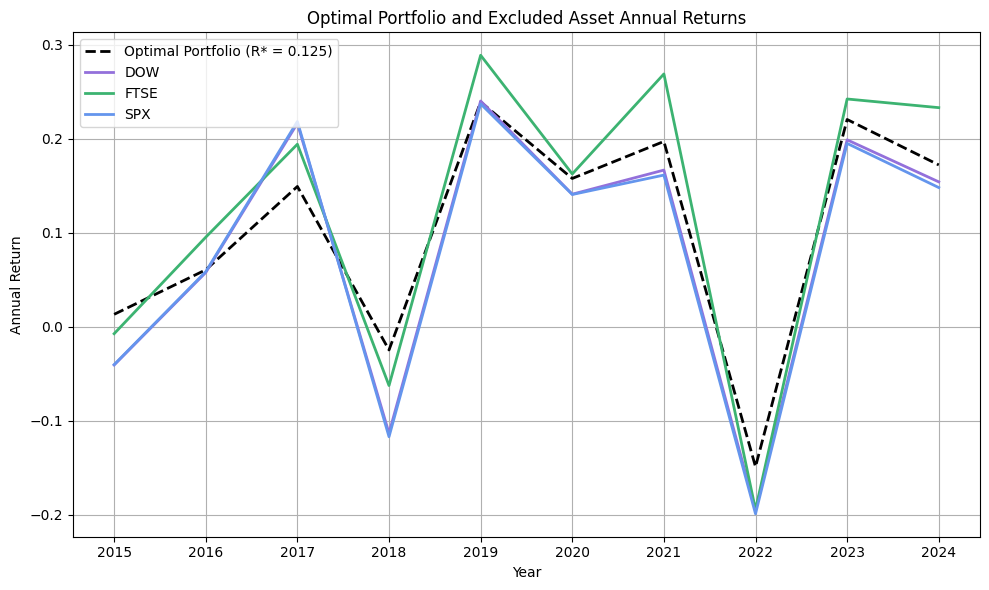

In [ ]:
# Calculate the annual returns for the optimal portfolio at risk level 0.125
optimal_portfolio_returns = []

# Calculate the portfolio return for each year based on the optimal weights at the target risk level
for year in range(2015, 2025):
    # Annual returns for the assets at the current year
    year_returns = [annual_returns[asset][year - 2015] for asset in relevant_assets]

    # Compute the portfolio return for the current year
    portfolio_return = np.dot(year_returns, [optimal_weights_at_target[asset] for asset in relevant_assets])
    optimal_portfolio_returns.append(portfolio_return)

# Include the excluded assets (W1DOW, SPX, FTWORLD) in the plot
excluded_assets_returns = {asset: annual_returns[asset] for asset in EXCLUDED_ASSETS}

# Plotting
plt.figure(figsize=(10, 6))

# Plot optimal portfolio returns
plt.plot(range(2015, 2025), optimal_portfolio_returns, label='Optimal Portfolio (R* = 0.125)', color='black', linestyle='--', linewidth=2)

# Plot returns for the excluded assets (W1DOW, SPX, FTWORLD)
for asset, color, label in zip(excluded_assets_returns.keys(), ['mediumpurple', 'mediumseagreen', 'cornflowerblue'], ['DOW', 'FTSE', 'SPX']):
    plt.plot(range(2015, 2025), excluded_assets_returns[asset], label=label, color=color, linewidth=2)

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Annual Return')
plt.title('Optimal Portfolio and Excluded Asset Annual Returns')

# Set x-axis ticks for each year
plt.xticks(range(2015, 2025), [str(year) for year in range(2015, 2025)])

# Show legend
plt.legend(loc='upper left')

# Show grid
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

## Maximize Return

In [ ]:
# Define the excluded assets
EXCLUDED_ASSETS = ["W1DOW", "FTWORLD", "SPX"]

# Function to optimize a single set of portfolio weights across all years
def optimize_fixed_portfolio(annual_returns, excluded_assets):
    relevant_assets = [asset for asset in annual_returns.keys() if asset not in excluded_assets]
    num_assets = len(relevant_assets)

    # Compute average annual returns for relevant assets
    avg_returns = np.mean([np.array([annual_returns[asset][year - 2015] for year in range(2015, 2025)]) for asset in relevant_assets], axis=1)
    avg_vols = np.mean([np.array([annual_vol[asset][year - 2015] for year in range(2015, 2025)]) for asset in relevant_assets], axis=1)

    # Compute average max excluded asset return
    avg_max_excluded_return = np.mean([max(annual_returns[asset][year - 2015] for asset in excluded_assets) for year in range(2015, 2025)])

    # Define objective function (maximize return difference)
    def objective(w):
        return -(np.dot(w, avg_returns) - avg_max_excluded_return)

    # Constraints: sum of weights = 1 (fully invested)
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

    # Bounds: long-only constraint (weights >= 0)
    bounds = [(0, 1) for _ in range(num_assets)]

    # Initial weights (equal allocation)
    initial_weights = np.ones(num_assets) / num_assets

    # Solve optimization
    result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)
    fixed_weights = dict(zip(relevant_assets, result.x))

    # Calculate portfolio returns and risks for all years
    fixed_portfolio_returns = [np.dot(result.x, [annual_returns[asset][year - 2015] for asset in relevant_assets]) for year in range(2015, 2025)]
    fixed_portfolio_risks = [np.sqrt(np.dot(result.x**2, [annual_vol[asset][year - 2015]**2 for asset in relevant_assets])) for year in range(2015, 2025)]

    return fixed_weights, fixed_portfolio_returns, fixed_portfolio_risks

# Run optimization
fixed_weights, fixed_portfolio_returns, fixed_portfolio_risks = optimize_fixed_portfolio(annual_returns, EXCLUDED_ASSETS)

# Extract excluded asset returns and risks for plotting
excluded_assets_returns = {asset: annual_returns[asset] for asset in EXCLUDED_ASSETS}
excluded_assets_risks = {asset: annual_vol[asset] for asset in EXCLUDED_ASSETS}

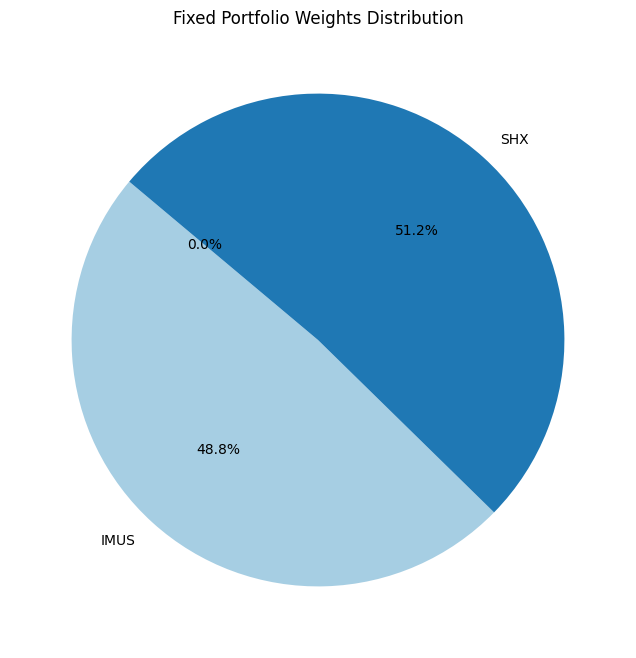

In [ ]:
# Plot pie chart of portfolio weights
aggregated_weights = {asset: weight for asset, weight in fixed_weights.items() if weight >= 0.05}
other_weight = sum(weight for asset, weight in fixed_weights.items() if weight < 0.05)
if other_weight > 0:
    aggregated_weights["Other"] = other_weight

plt.figure(figsize=(8, 8))
plt.pie(aggregated_weights.values(), labels=[asset if weight >= 0.05 else '' for asset, weight in aggregated_weights.items()], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Fixed Portfolio Weights Distribution")
plt.show()

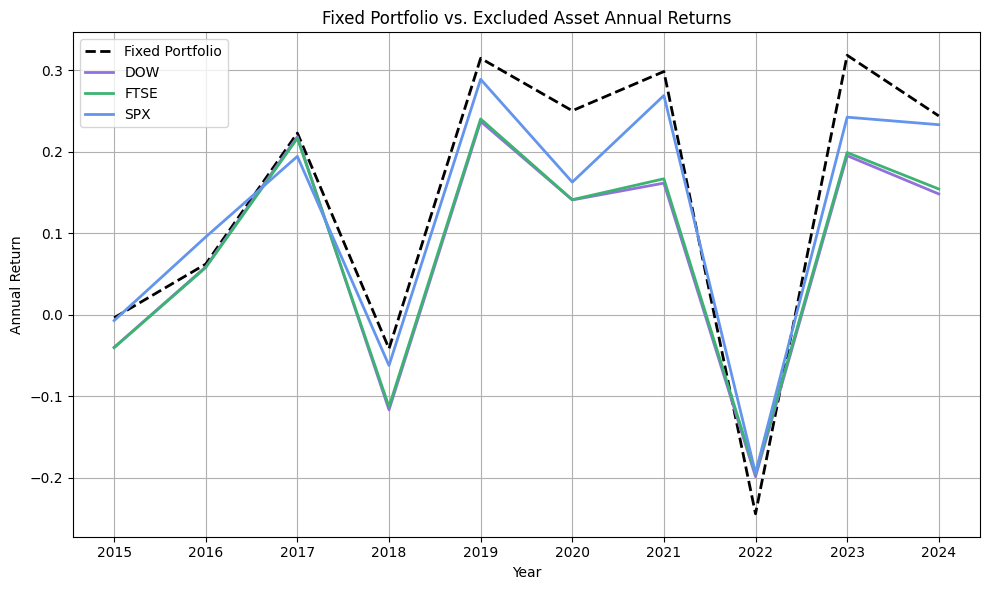

In [ ]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(range(2015, 2025), fixed_portfolio_returns, label='Fixed Portfolio', color='black', linestyle='--', linewidth=2)

# Plot excluded assets
for asset, color, label in zip(EXCLUDED_ASSETS, ['mediumpurple', 'mediumseagreen', 'cornflowerblue'], ['DOW', 'FTSE', 'SPX']):
    plt.plot(range(2015, 2025), excluded_assets_returns[asset], label=label, color=color, linewidth=2)

plt.xlabel('Year')
plt.ylabel('Annual Return')
plt.title('Fixed Portfolio vs. Excluded Asset Annual Returns')
plt.xticks(range(2015, 2025), [str(year) for year in range(2015, 2025)])
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

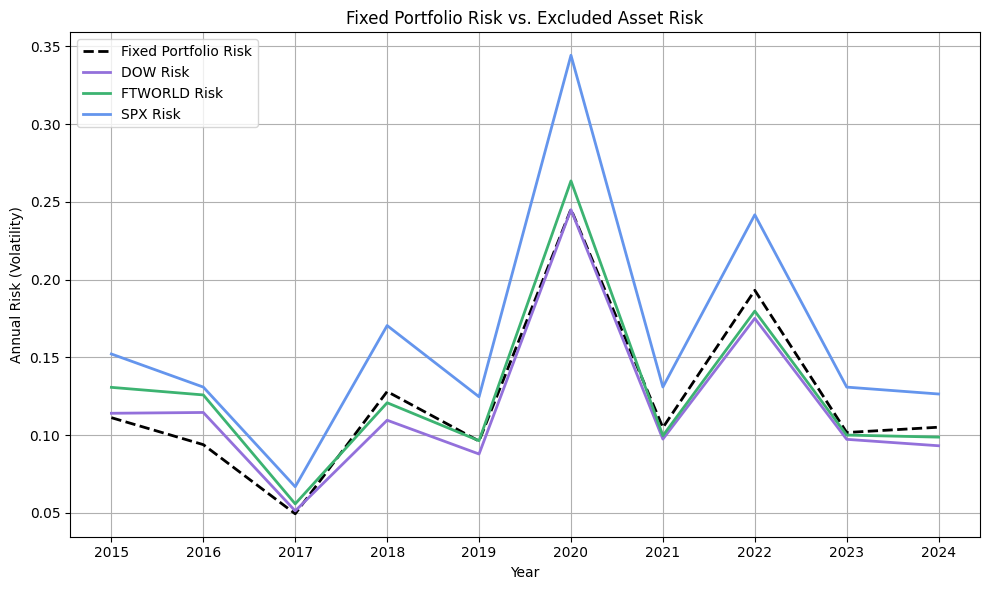

In [ ]:
# Plot risk comparison
plt.figure(figsize=(10, 6))
plt.plot(range(2015, 2025), fixed_portfolio_risks, label='Fixed Portfolio Risk', color='black', linestyle='--', linewidth=2)

for asset, color, label in zip(EXCLUDED_ASSETS, ['mediumpurple', 'mediumseagreen', 'cornflowerblue'], ['DOW', 'FTWORLD', 'SPX']):
    plt.plot(range(2015, 2025), excluded_assets_risks[asset], label=label + ' Risk', color=color, linewidth=2)

plt.xlabel('Year')
plt.ylabel('Annual Risk (Volatility)')
plt.title('Fixed Portfolio Risk vs. Excluded Asset Risk')
plt.xticks(range(2015, 2025), [str(year) for year in range(2015, 2025)])
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def plot_efficient_frontier(annual_returns, annual_vol, cov_matrix, valid_assets):
    risk_levels = np.linspace(0, 0.225, 91)  # Define different risk levels
    efficient_returns = []
    efficient_risks = []

    mean_returns = pd.DataFrame(annual_returns, index=range(2015, 2025))[valid_assets].mean()

    for max_risk in risk_levels:
        num_assets = len(valid_assets)
        initial_weights = np.ones(num_assets) / num_assets
        bounds = [(0, 1) for _ in range(num_assets)]
        constraints = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'ineq', 'fun': lambda w: max_risk - np.sqrt(w @ cov_matrix @ w)}
        ]

        def neg_return(w):
            return -np.dot(w, mean_returns)

        result = minimize(neg_return, initial_weights, bounds=bounds, constraints=constraints)

        if result.success:
            optimized_weights = result.x
            efficient_returns.append(-result.fun)
            efficient_risks.append(np.sqrt(optimized_weights @ cov_matrix @ optimized_weights))

    plt.figure(figsize=(10, 6))
    plt.plot(efficient_risks, efficient_returns, marker="o", linestyle="-", color="blue", label="Efficient Frontier")

    plt.xlabel("Annualized Risk (Standard Deviation)")
    plt.ylabel("Annualized Return")
    plt.title("Efficient Frontier based on Portfolio Optimization")
    plt.legend()
    plt.grid(True)
    plt.show()

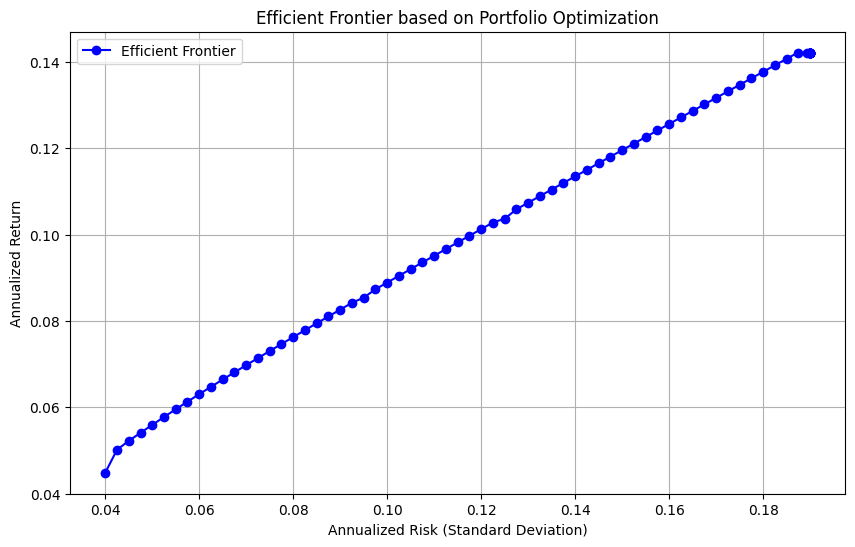

In [ ]:
plot_efficient_frontier(annual_returns, annual_vol, cov_matrix, valid_assets)

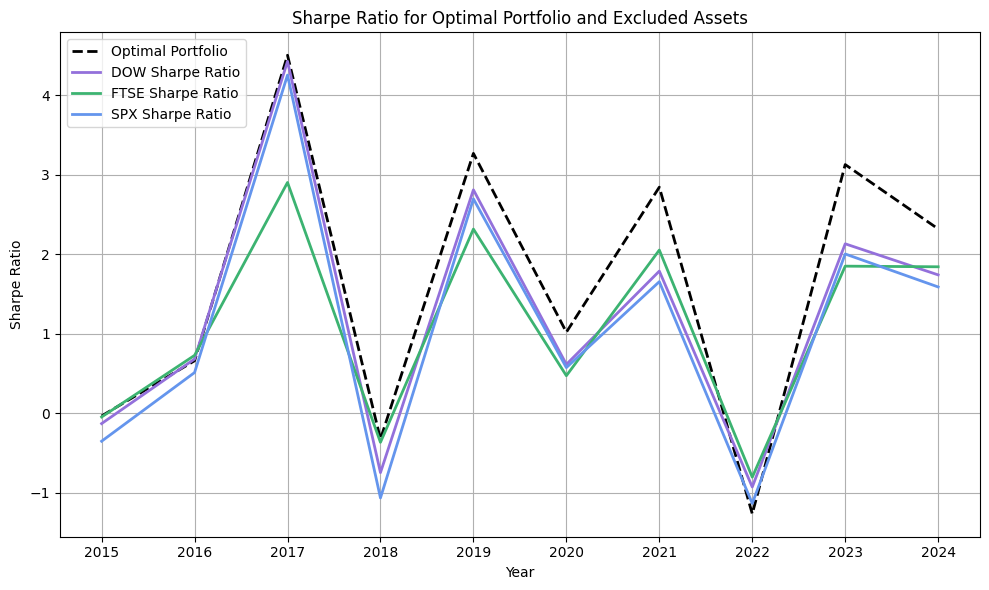

In [ ]:
# Function to calculate Sharpe Ratio for yearly returns and risks
def calculate_sharpe_ratio(returns, risks, risk_free_rate=0):
    return (returns - risk_free_rate) / risks

# Modify the optimize_fixed_portfolio function to return the Sharpe ratio for each year
def optimize_fixed_portfolio(annual_returns, annual_vol, excluded_assets):
    relevant_assets = [asset for asset in annual_returns.keys() if asset not in excluded_assets]
    num_assets = len(relevant_assets)

    # Compute average annual returns for relevant assets
    avg_returns = np.mean([np.array([annual_returns[asset][year - 2015] for year in range(2015, 2025)]) for asset in relevant_assets], axis=1)
    avg_vols = np.mean([np.array([annual_vol[asset][year - 2015] for year in range(2015, 2025)]) for asset in relevant_assets], axis=1)

    # Compute average max excluded asset return
    avg_max_excluded_return = np.mean([max(annual_returns[asset][year - 2015] for asset in excluded_assets) for year in range(2015, 2025)])

    # Define objective function (maximize return difference)
    def objective(w):
        return -(np.dot(w, avg_returns) - avg_max_excluded_return)

    # Constraints: sum of weights = 1 (fully invested)
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

    # Bounds: long-only constraint (weights >= 0)
    bounds = [(0, 1) for _ in range(num_assets)]

    # Initial weights (equal allocation)
    initial_weights = np.ones(num_assets) / num_assets

    # Solve optimization
    result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)
    fixed_weights = dict(zip(relevant_assets, result.x))

    # Calculate yearly returns and risks for the optimal portfolio
    optimal_portfolio_returns = []
    optimal_portfolio_risks = []

    for year in range(2015, 2025):
        yearly_return = np.dot(result.x, [annual_returns[asset][year - 2015] for asset in relevant_assets])
        yearly_risk = np.sqrt(np.dot(result.x**2, [annual_vol[asset][year - 2015]**2 for asset in relevant_assets]))

        optimal_portfolio_returns.append(yearly_return)
        optimal_portfolio_risks.append(yearly_risk)

    # Calculate Sharpe ratio for each year of the optimal portfolio
    sharpe_ratios_optimal = [calculate_sharpe_ratio(r, r_s) for r, r_s in zip(optimal_portfolio_returns, optimal_portfolio_risks)]

    # Extract excluded asset returns and risks for plotting
    excluded_assets_returns = {asset: annual_returns[asset] for asset in excluded_assets}
    excluded_assets_risks = {asset: annual_vol[asset] for asset in excluded_assets}

    # Calculate Sharpe ratio for each year of the excluded assets
    sharpe_ratios_excluded = {}
    for asset in excluded_assets:
        yearly_returns = excluded_assets_returns[asset]
        yearly_risks = excluded_assets_risks[asset]
        sharpe_ratios_excluded[asset] = [calculate_sharpe_ratio(r, r_s) for r, r_s in zip(yearly_returns, yearly_risks)]

    return fixed_weights, sharpe_ratios_optimal, sharpe_ratios_excluded

# Run optimization
fixed_weights, sharpe_ratios_optimal, sharpe_ratios_excluded = optimize_fixed_portfolio(annual_returns, annual_vol, EXCLUDED_ASSETS)

# Plot Sharpe ratios for the optimal portfolio and excluded assets
plt.figure(figsize=(10, 6))

# Plot Sharpe ratio for the optimal portfolio
plt.plot(range(2015, 2025), sharpe_ratios_optimal, label='Optimal Portfolio', color='black', linestyle='--', linewidth=2)

# Plot Sharpe ratios for the excluded assets
for asset, color, label in zip(EXCLUDED_ASSETS, ['mediumpurple', 'mediumseagreen', 'cornflowerblue'], ['DOW', 'FTSE', 'SPX']):
    plt.plot(range(2015, 2025), sharpe_ratios_excluded[asset], label=f'{label} Sharpe Ratio', color=color, linewidth=2)

plt.xlabel('Year')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio for Optimal Portfolio and Excluded Assets')
plt.xticks(range(2015, 2025), [str(year) for year in range(2015, 2025)])
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## Backtest 2005-2014

In [ ]:
def calculate_historical_metrics(file_paths, start_year, end_year):
    annual_returns = {}

    for file_path in file_paths:
        # Load the Excel file
        df = pd.read_excel(file_path)

        # Extract file name without extension
        file_name = os.path.splitext(os.path.basename(file_path))[0]

        # Convert first column to datetime
        date_column = df.columns[0]
        df[date_column] = pd.to_datetime(df[date_column], format='%m/%d/%Y', errors='coerce')

        # Ensure the second column (closing prices) is numeric
        price_column = df.columns[1]
        df[price_column] = pd.to_numeric(df[price_column], errors='coerce')

        # Drop rows with NaN values
        df.dropna(subset=[date_column, price_column], inplace=True)

        # Sort by date
        df.sort_values(by=date_column, inplace=True)

        # Calculate daily returns
        df['Returns'] = df[price_column].pct_change()

        # Initialize list for annual returns
        yearly_returns = []

        for year in range(start_year, end_year + 1):
            yearly_data = df[df[date_column].dt.year == year]['Returns'].dropna()

            if not yearly_data.empty:
                # Compute annual return
                yearly_returns.append((yearly_data + 1).prod() - 1)
            else:
                yearly_returns.append(None)

        # Store results
        annual_returns[file_name] = yearly_returns

    return annual_returns

In [ ]:
# Define year range
start_year = 2005
end_year = 2014

# Calculate metrics for full period
annual_returns = calculate_historical_metrics(file_paths, start_year, end_year)

# Define given portfolio weights
imus_weight = 0.48779401310617587
shx_weight = 0.5122059868938257

# Extract years
years = list(range(start_year, end_year + 1))

# Extract annual returns for IMUS and SHX
imus_returns = [annual_returns['IMUS'][year - start_year] for year in years]
shx_returns = [annual_returns['SHX'][year - start_year] for year in years]

# Compute portfolio returns
portfolio_returns = [
    imus_weight * imus + shx_weight * shx if imus is not None and shx is not None else None
    for imus, shx in zip(imus_returns, shx_returns)
]

djia_values = [1.7222658624060965, 19.046705356563027, 8.884634935591457, -31.9305585729856, 22.683315077714067, 14.063472342588556, 8.382359972840899, 10.237540516180674, 29.65390556840647, 10.041781465894829]
ftworld_values = [11.3826103088958, 21.8365038274955, 12.3427113179495, -42.0741198959542, 35.4396806778592, 12.6634309017701, -7.72474085462043, 16.4885581603536, 22.6886540719393, 4.22673058018043]  # FTWORLD annual returns
spx_values = [3.0035481475369163, 13.61852118881679, 3.5323979411972184, -38.490874421138656, 23.46102745792735, 12.779122948614475, 0.0, 13.406488549618324, 29.603141214415942, 11.388227656351436]  # SPX annual returns


# Normalize values by dividing by 100
djia_values = [x / 100 for x in djia_values]
ftworld_values = [x / 100 for x in ftworld_values]
spx_values = [x / 100 for x in spx_values]

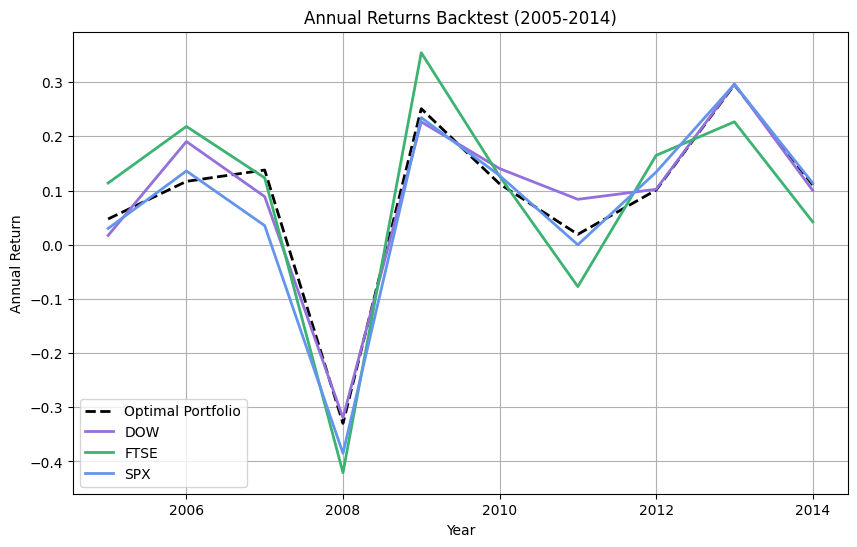

In [ ]:
# Plot the portfolio returns for 2005-2014
plt.figure(figsize=(10, 6))
plt.plot(years, portfolio_returns, label='Optimal Portfolio', color='black', linestyle='--', linewidth=2)
plt.plot(years, djia_values, color="mediumpurple", label="DOW", linewidth=2)
plt.plot(years, ftworld_values, color="mediumseagreen", label="FTSE", linewidth=2)
plt.plot(years, spx_values, color="cornflowerblue", label="SPX", linewidth=2)

plt.xlabel("Year")
plt.ylabel("Annual Return")
plt.title("Annual Returns Backtest (2005-2014)")
plt.legend()
plt.grid(True)

plt.show()

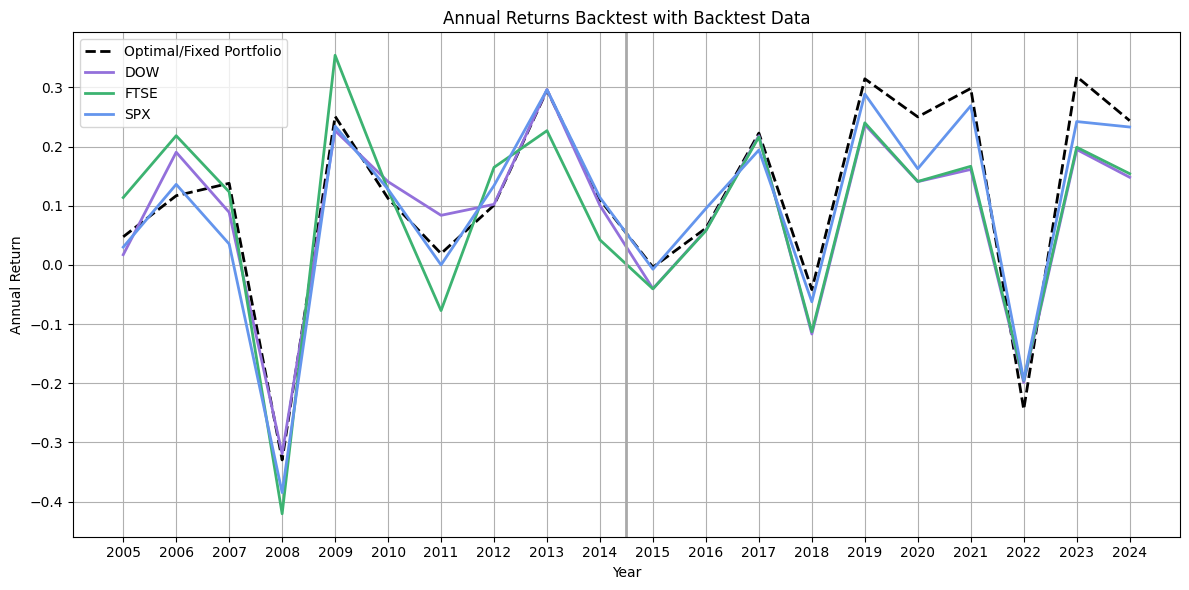

In [ ]:
  # Data for 2005-2014
years_1 = list(range(2005, 2015))
portfolio_returns_1 = portfolio_returns  # Assuming this is the data for 2005-2014
djia_values_1 = djia_values
ftworld_values_1 = ftworld_values
spx_values_1 = spx_values

# Data for 2015-2024
years_2 = list(range(2014, 2025))  # Start from 2014 to connect plots
portfolio_returns_2 = [portfolio_returns_1[-1]] + fixed_portfolio_returns  # Connects the two portfolio lines
djia_values_2 = [djia_values_1[-1]] + excluded_assets_returns['W1DOW']
ftworld_values_2 = [ftworld_values_1[-1]] + excluded_assets_returns['FTWORLD']
spx_values_2 = [spx_values_1[-1]] + excluded_assets_returns['SPX']

# Create the combined plot
plt.figure(figsize=(12, 6))

# Plot full dataset ensuring smooth transition
plt.plot(years_1 + years_2[1:], portfolio_returns_1 + portfolio_returns_2[1:],
         label='Optimal/Fixed Portfolio', color='black', linestyle='--', linewidth=2)
plt.plot(years_1 + years_2[1:], djia_values_1 + djia_values_2[1:],
         color="mediumpurple", label="DOW", linewidth=2)
plt.plot(years_1 + years_2[1:], ftworld_values_1 + ftworld_values_2[1:],
         color="mediumseagreen", label="FTSE", linewidth=2)
plt.plot(years_1 + years_2[1:], spx_values_1 + spx_values_2[1:],
         color="cornflowerblue", label="SPX", linewidth=2)

# Add vertical demarcation line at 2014.5
plt.axvline(x=2014.5, color='darkgray', linestyle='-', linewidth=2)

# Labels and formatting
plt.xlabel("Year")
plt.ylabel("Annual Return")
plt.title("Annual Returns Backtest with Backtest Data")
plt.xticks(range(2005, 2025))  # Ensures only whole numbers appear on x-axis
plt.legend(loc='upper left')  # Single legend
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

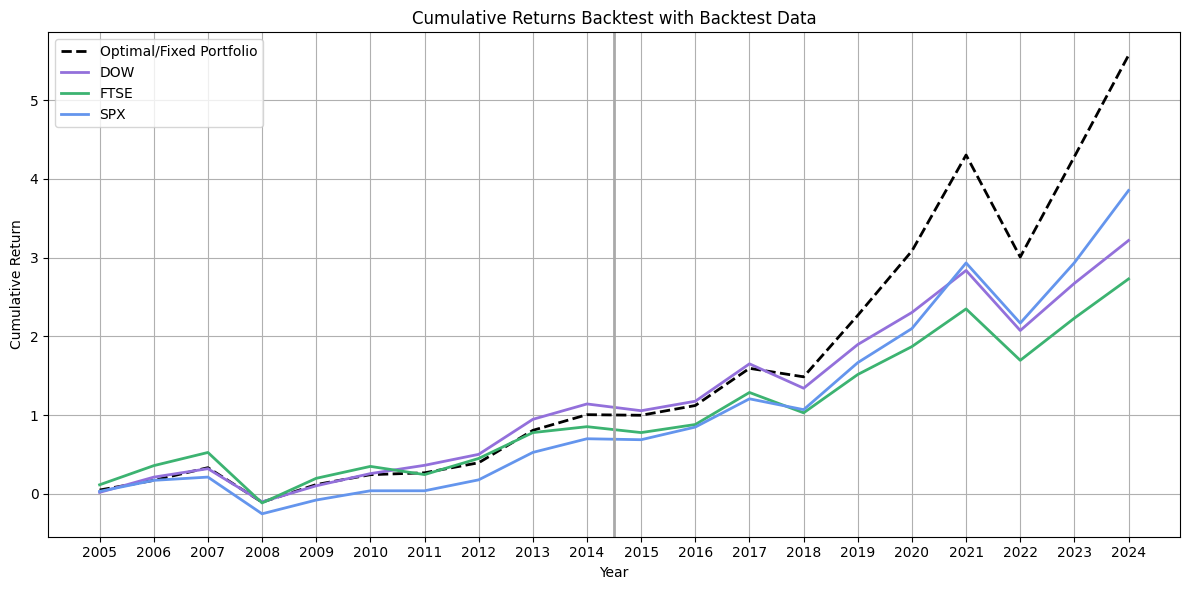

In [ ]:
# Function to calculate cumulative returns
def calculate_cumulative_returns(returns):
    cumulative_returns = np.cumprod(1 + np.array(returns)) - 1
    return cumulative_returns

# Data for 2005-2014
years_1 = list(range(2005, 2015))
portfolio_returns_1 = portfolio_returns  # Assuming this is the data for 2005-2014
djia_values_1 = djia_values
ftworld_values_1 = ftworld_values
spx_values_1 = spx_values

# Data for 2015-2024
years_2 = list(range(2014, 2025))  # Start from 2014 to connect plots
portfolio_returns_2 = [portfolio_returns_1[-1]] + fixed_portfolio_returns  # Connects the two portfolio lines
djia_values_2 = [djia_values_1[-1]] + excluded_assets_returns['W1DOW']
ftworld_values_2 = [ftworld_values_1[-1]] + excluded_assets_returns['FTWORLD']
spx_values_2 = [spx_values_1[-1]] + excluded_assets_returns['SPX']

# Calculate cumulative returns for each series
portfolio_cumulative_returns = calculate_cumulative_returns(portfolio_returns_1 + portfolio_returns_2[1:])
djia_cumulative_returns = calculate_cumulative_returns(djia_values_1 + djia_values_2[1:])
ftworld_cumulative_returns = calculate_cumulative_returns(ftworld_values_1 + ftworld_values_2[1:])
spx_cumulative_returns = calculate_cumulative_returns(spx_values_1 + spx_values_2[1:])

# Create the combined plot
plt.figure(figsize=(12, 6))

# Plot cumulative returns
plt.plot(years_1 + years_2[1:], portfolio_cumulative_returns,
         label='Optimal/Fixed Portfolio', color='black', linestyle='--', linewidth=2)
plt.plot(years_1 + years_2[1:], djia_cumulative_returns,
         color="mediumpurple", label="DOW", linewidth=2)
plt.plot(years_1 + years_2[1:], ftworld_cumulative_returns,
         color="mediumseagreen", label="FTSE", linewidth=2)
plt.plot(years_1 + years_2[1:], spx_cumulative_returns,
         color="cornflowerblue", label="SPX", linewidth=2)

# Add vertical demarcation line at 2014.5
plt.axvline(x=2014.5, color='darkgray', linestyle='-', linewidth=2)

# Labels and formatting
plt.xlabel("Year")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Returns Backtest with Backtest Data")
plt.xticks(range(2005, 2025))  # Ensures only whole numbers appear on x-axis
plt.legend(loc='upper left')  # Single legend
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

# **MVO Backtest on 2015-2022, Display 2023-2024**

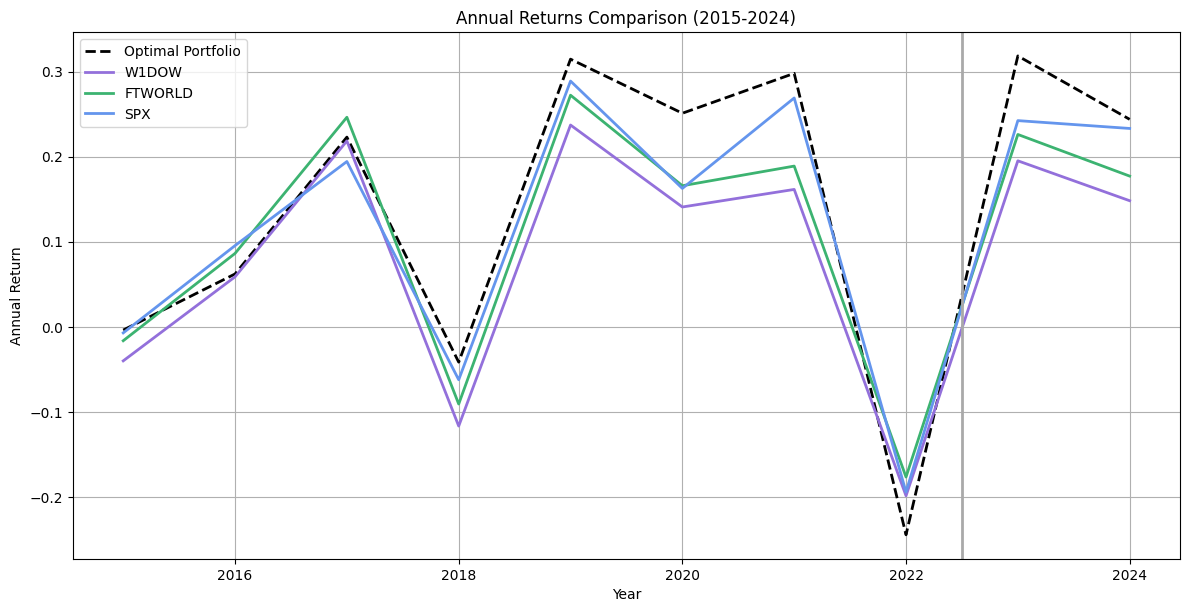

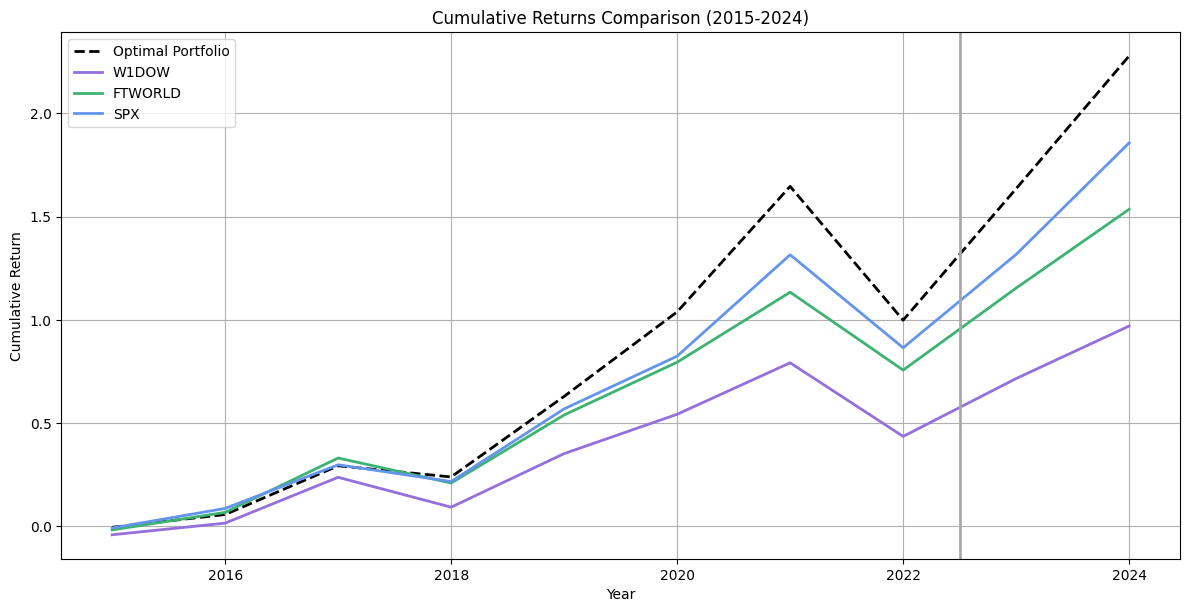

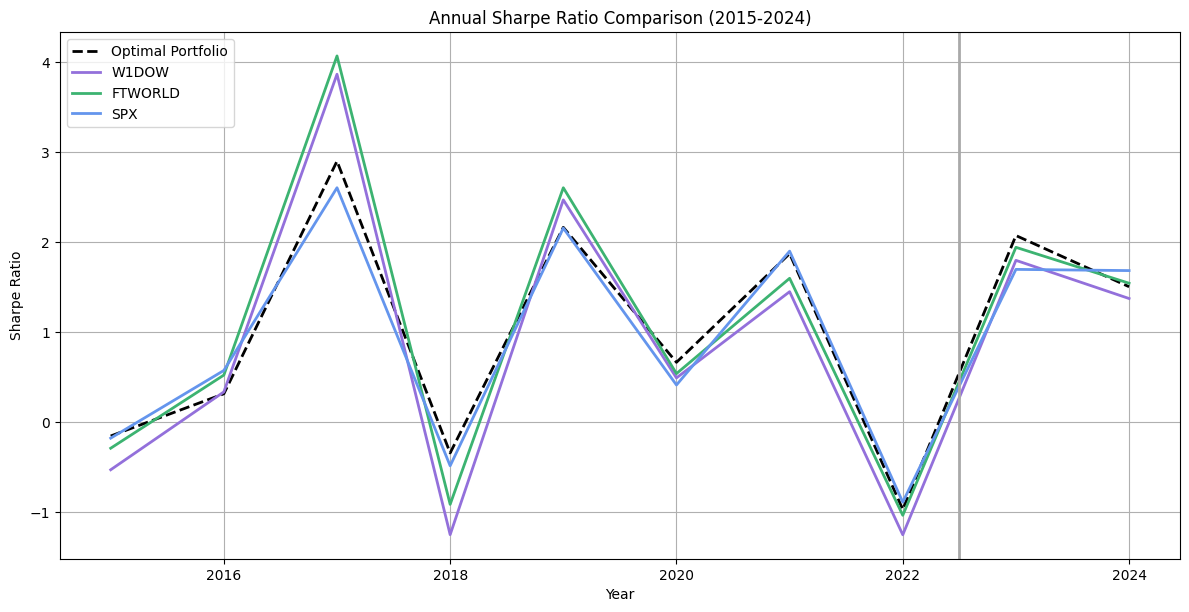

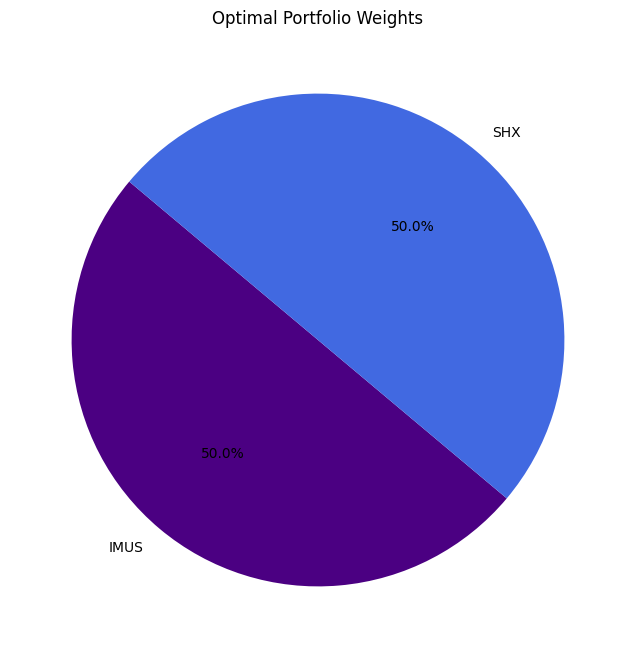

In [ ]:
# Define excluded assets
EXCLUDED_ASSETS = ["W1DOW", "FTWORLD", "SPX"]

# Function to calculate annual metrics
def calculate_annual_metrics(file_paths):
    annual_returns, annual_vol, annual_cvar = {}, {}, {}
    start_year, end_year = 2015, 2024

    for file_path in file_paths:
        df = pd.read_excel(file_path)
        file_name = os.path.splitext(os.path.basename(file_path))[0]
        date_column, price_column = df.columns[0], df.columns[1]
        df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
        df[price_column] = pd.to_numeric(df[price_column], errors='coerce')
        df.dropna(subset=[date_column, price_column], inplace=True)
        df.sort_values(by=date_column, inplace=True)
        df['Returns'] = df[price_column].pct_change()

        yearly_returns, yearly_vol, yearly_cvar = [], [], []
        for year in range(start_year, end_year + 1):
            yearly_data = df[df[date_column].dt.year == year]['Returns'].dropna()
            if not yearly_data.empty:
                yearly_returns.append((yearly_data + 1).prod() - 1)
                yearly_vol.append(yearly_data.std() * np.sqrt(252))
                var_95 = yearly_data.quantile(0.05)
                yearly_cvar.append(yearly_data[yearly_data <= var_95].mean())
            else:
                yearly_returns.append(None)
                yearly_vol.append(None)
                yearly_cvar.append(None)

        annual_returns[file_name] = yearly_returns
        annual_vol[file_name] = yearly_vol
        annual_cvar[file_name] = yearly_cvar

    return annual_returns, annual_vol, annual_cvar

# Function to optimize portfolio weights
def optimize_portfolio(annual_returns):
    relevant_assets = [asset for asset in annual_returns.keys() if asset not in EXCLUDED_ASSETS]
    num_assets = len(relevant_assets)
    avg_returns = np.mean([
        [annual_returns[asset][year - 2015] for year in range(2015, 2023)]
        for asset in relevant_assets
    ], axis=1)

    def objective(w):
        return -np.dot(w, avg_returns)

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 0.5) for _ in range(num_assets)]
    initial_weights = np.ones(num_assets) / num_assets
    result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)
    return dict(zip(relevant_assets, result.x))

# Function to compute weighted portfolio values
def compute_portfolio_values(weights, annual_data, years):
    return [np.dot(list(weights.values()), [annual_data[asset][year - 2015] for asset in weights.keys()]) for year in years]

# Function to compute Sharpe Ratio
def compute_sharpe_ratio(returns, volatilities, risk_free_rate=0.02):
    return [(r - risk_free_rate) / v if v != 0 else None for r, v in zip(returns, volatilities)]

# Function to compute cumulative returns
def calculate_cumulative_returns(returns):
    return np.cumprod(1 + np.array(returns)) - 1

# Function to plot results
def plot_results(portfolio_values, excluded_assets_values, years, ylabel, title):
    plt.figure(figsize=(12, 6))
    plt.plot(years, portfolio_values, label="Optimal Portfolio", color="black", linestyle="--", linewidth=2)
    for asset, color in zip(EXCLUDED_ASSETS, ["mediumpurple", "mediumseagreen", "cornflowerblue"]):
        plt.plot(years, excluded_assets_values[asset], label=asset, linewidth=2, color=color)

    plt.axvline(x=2022.5, color="darkgray", linestyle="-", linewidth=2)
    plt.xlabel("Year")
    plt.ylabel(ylabel)
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.tight_layout()
    plt.title(title)
    plt.show()

# Function to plot pie chart of portfolio weights
def plot_portfolio_weights(weights):
    categorized_weights = {k: v for k, v in weights.items() if v >= 0.05}
    other_weight = sum(v for k, v in weights.items() if v < 0.05)
    if other_weight > 0:
        categorized_weights["Other"] = other_weight

    labels = [k if v >= 0.05 else "" for k, v in categorized_weights.items()]
    sizes = list(categorized_weights.values())
    colors = ["royalblue" if k == "SHX" else "indigo" if k == "IMUS" else c
              for k, c in zip(labels, plt.cm.Paired.colors)]

    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct=lambda p: f'{p:.1f}%' if p > 5 else '',
            startangle=140, colors=colors)
    plt.title("Optimal Portfolio Weights")
    plt.show()

# Main execution
annual_returns, annual_vol, annual_cvar = calculate_annual_metrics(file_paths)
fixed_weights = optimize_portfolio(annual_returns)

# Compute returns, volatility, and Sharpe Ratio for 2015-2024
portfolio_returns = compute_portfolio_values(fixed_weights, annual_returns, range(2015, 2025))
portfolio_vol = compute_portfolio_values(fixed_weights, annual_vol, range(2015, 2025))
portfolio_sharpe = compute_sharpe_ratio(portfolio_returns, portfolio_vol)

# Compute cumulative returns
portfolio_cumulative_returns = calculate_cumulative_returns(portfolio_returns)
excluded_assets_cumulative_returns = {asset: calculate_cumulative_returns([annual_returns[asset][year - 2015] for year in range(2015, 2025)]) for asset in EXCLUDED_ASSETS}

# Plot results
plot_results(portfolio_returns, {asset: [annual_returns[asset][year - 2015] for year in range(2015, 2025)] for asset in EXCLUDED_ASSETS}, range(2015, 2025), "Annual Return", "Annual Returns Comparison (2015-2024)")
plot_results(portfolio_cumulative_returns, excluded_assets_cumulative_returns, range(2015, 2025), "Cumulative Return", "Cumulative Returns Comparison (2015-2024)")
plot_results(portfolio_sharpe, {asset: compute_sharpe_ratio([annual_returns[asset][year - 2015] for year in range(2015, 2025)], [annual_vol[asset][year - 2015] for year in range(2015, 2025)]) for asset in EXCLUDED_ASSETS}, range(2015, 2025), "Sharpe Ratio", "Annual Sharpe Ratio Comparison (2015-2024)")

# Plot portfolio weights
plot_portfolio_weights(fixed_weights)

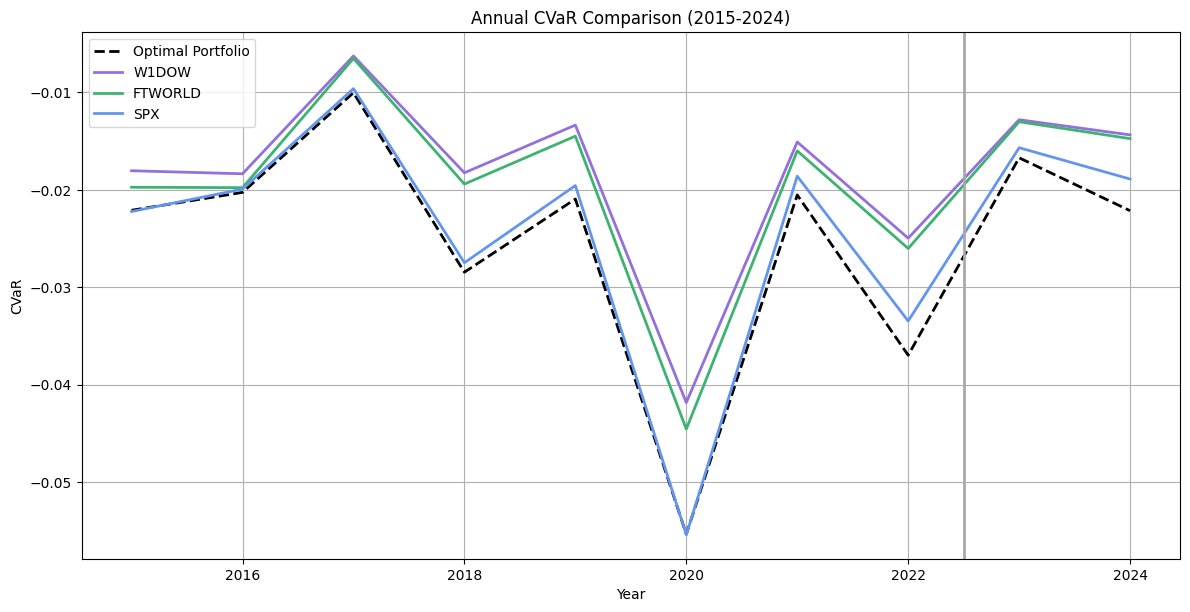

In [ ]:
# Compute returns and CVaR for 2015-2024
portfolio_cvar = compute_portfolio_values(fixed_weights, annual_cvar, range(2015, 2025))

# Extract benchmark values
excluded_assets_cvar = {asset: [annual_cvar[asset][year - 2015] for year in range(2015, 2025)] for asset in EXCLUDED_ASSETS}

# Plot results
plot_results(portfolio_cvar, excluded_assets_cvar, range(2015, 2025), "CVaR", "Annual CVaR Comparison (2015-2024)")

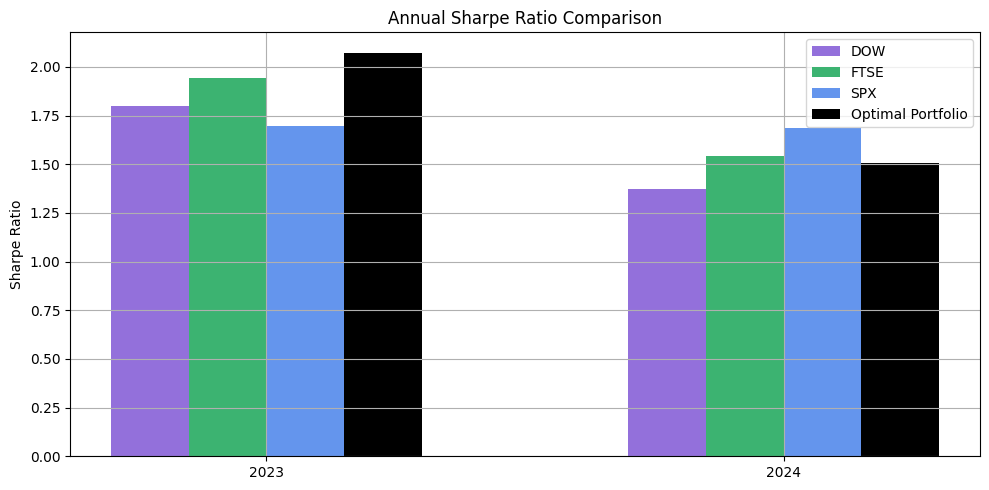

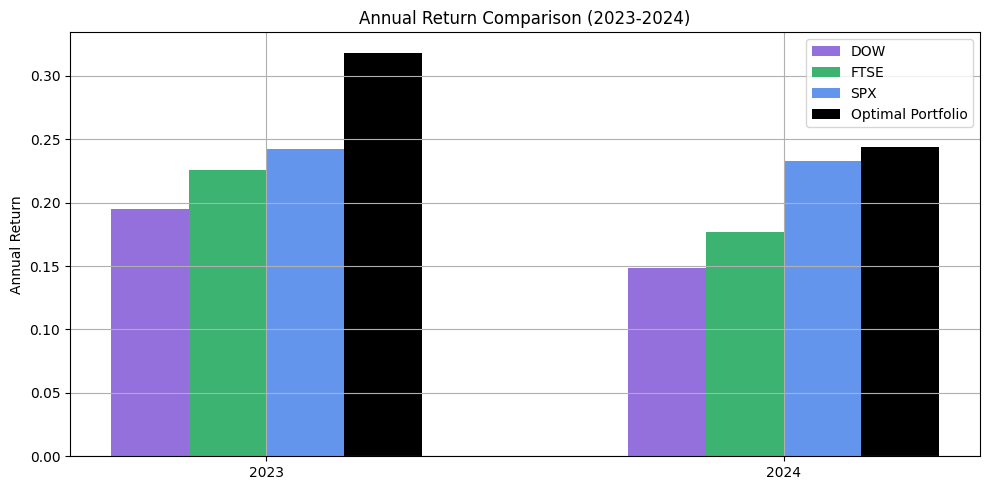

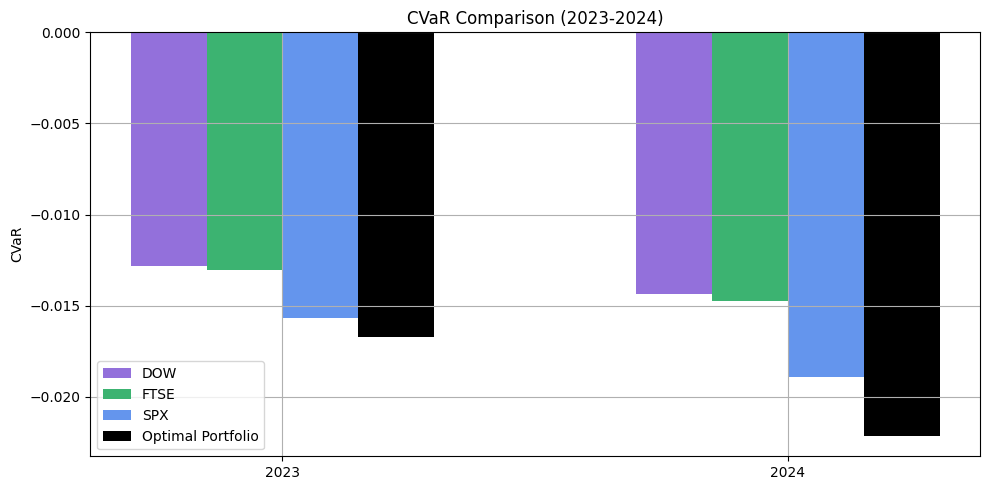

In [ ]:
# Function to compute Sharpe Ratio
def compute_sharpe_ratio(returns, volatilities, risk_free_rate=0.02):
    return [(r - risk_free_rate) / v if v != 0 else None for r, v in zip(returns, volatilities)]

# Function to plot bar charts
def plot_bar_charts(portfolio_values, excluded_assets_values, years, ylabel, title):
    import matplotlib.pyplot as plt
    import numpy as np

    x = np.arange(len(years))
    bar_width = 0.15

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(x - bar_width * 1.5, excluded_assets_values["W1DOW"], bar_width, label="DOW", color="mediumpurple")
    ax.bar(x - bar_width * 0.5, excluded_assets_values["FTWORLD"], bar_width, label="FTSE", color="mediumseagreen")
    ax.bar(x + bar_width * 0.5, excluded_assets_values["SPX"], bar_width, label="SPX", color="cornflowerblue")
    ax.bar(x + bar_width * 1.5, portfolio_values, bar_width, label="Optimal Portfolio", color="black")

    ax.set_xticks(x)
    ax.set_xticklabels(years)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Compute returns, volatility, and Sharpe Ratio for 2015-2024
portfolio_returns = compute_portfolio_values(fixed_weights, annual_returns, range(2023, 2025))
portfolio_cvar = compute_portfolio_values(fixed_weights, annual_cvar, range(2023, 2025))
portfolio_sharpe = compute_sharpe_ratio(portfolio_returns, portfolio_vol)

# Extract benchmark values for 2015-2024
excluded_assets_returns = {asset: [annual_returns[asset][year - 2015] for year in range(2023, 2025)] for asset in EXCLUDED_ASSETS}
excluded_assets_cvar = {asset: [annual_cvar[asset][year - 2015] for year in range(2023, 2025)] for asset in EXCLUDED_ASSETS}
excluded_assets_vol = {asset: [annual_vol[asset][year - 2015] for year in range(2023, 2025)] for asset in EXCLUDED_ASSETS}
excluded_assets_sharpe = {asset: compute_sharpe_ratio(excluded_assets_returns[asset], excluded_assets_vol[asset]) for asset in EXCLUDED_ASSETS}

# Plot bar charts
plot_bar_charts(portfolio_sharpe, excluded_assets_sharpe, range(2023, 2025), "Sharpe Ratio", "Annual Sharpe Ratio Comparison")
plot_bar_charts(portfolio_returns, excluded_assets_returns, [2023, 2024], "Annual Return", "Annual Return Comparison (2023-2024)")
plot_bar_charts(portfolio_cvar, excluded_assets_cvar, [2023, 2024], "CVaR", "CVaR Comparison (2023-2024)")

# MVO with no max weight constraint

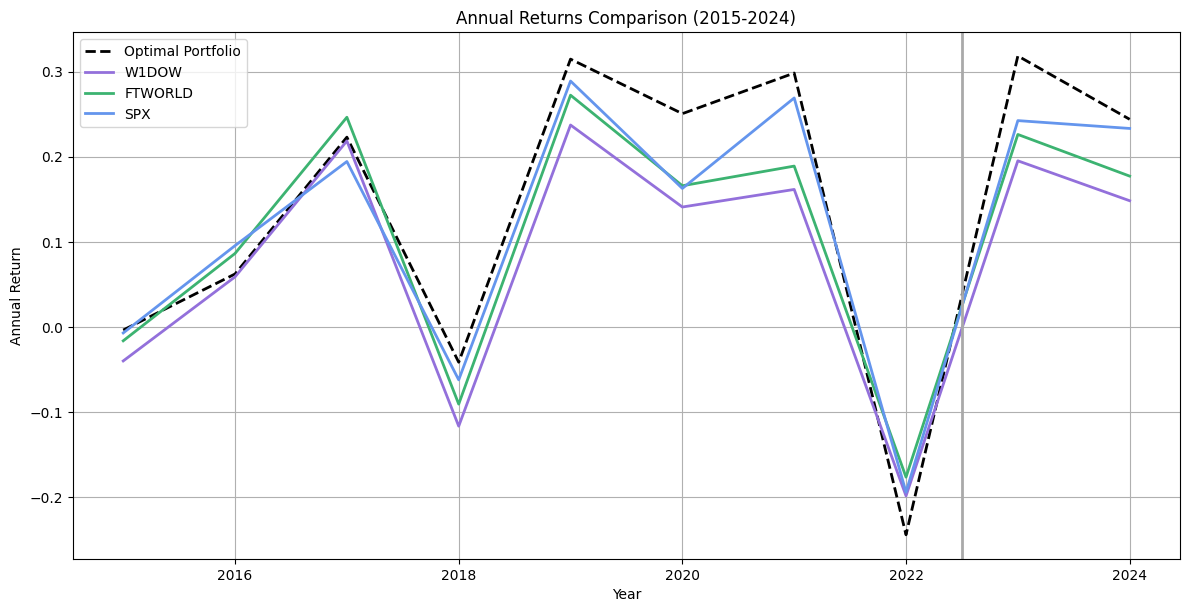

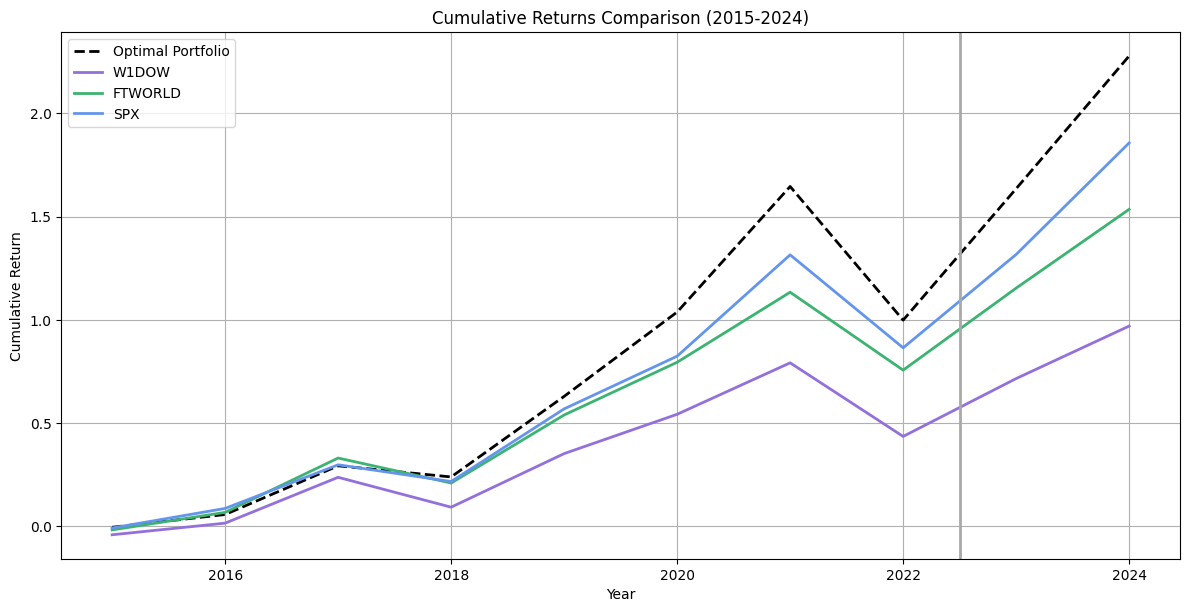

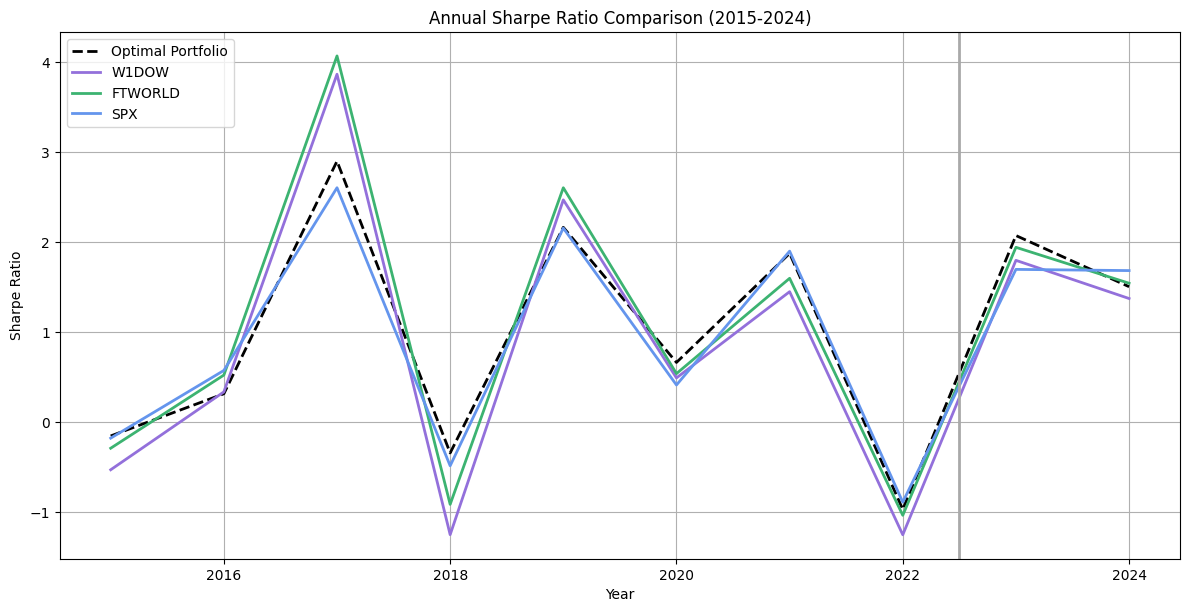

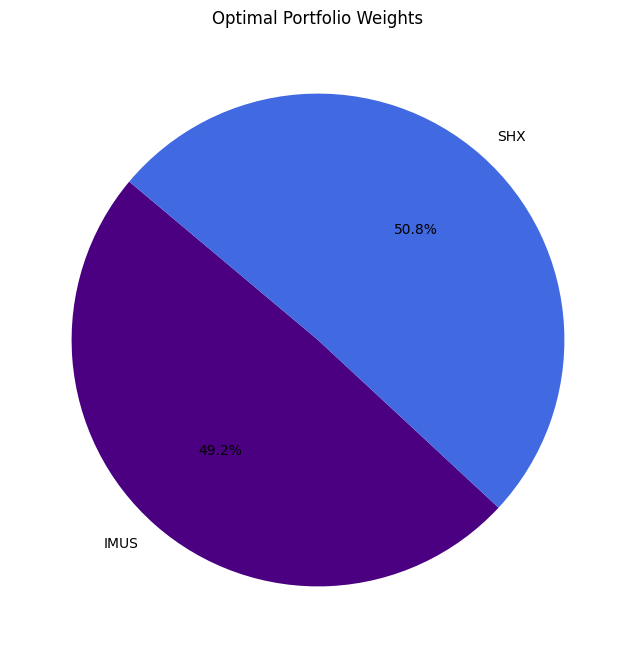

In [ ]:
# Define excluded assets
EXCLUDED_ASSETS = ["W1DOW", "FTWORLD", "SPX"]

# Function to calculate annual metrics
def calculate_annual_metrics(file_paths):
    annual_returns, annual_vol, annual_cvar = {}, {}, {}
    start_year, end_year = 2015, 2024

    for file_path in file_paths:
        df = pd.read_excel(file_path)
        file_name = os.path.splitext(os.path.basename(file_path))[0]
        date_column, price_column = df.columns[0], df.columns[1]
        df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
        df[price_column] = pd.to_numeric(df[price_column], errors='coerce')
        df.dropna(subset=[date_column, price_column], inplace=True)
        df.sort_values(by=date_column, inplace=True)
        df['Returns'] = df[price_column].pct_change()

        yearly_returns, yearly_vol, yearly_cvar = [], [], []
        for year in range(start_year, end_year + 1):
            yearly_data = df[df[date_column].dt.year == year]['Returns'].dropna()
            if not yearly_data.empty:
                yearly_returns.append((yearly_data + 1).prod() - 1)
                yearly_vol.append(yearly_data.std() * np.sqrt(252))
                var_95 = yearly_data.quantile(0.05)
                yearly_cvar.append(yearly_data[yearly_data <= var_95].mean())
            else:
                yearly_returns.append(None)
                yearly_vol.append(None)
                yearly_cvar.append(None)

        annual_returns[file_name] = yearly_returns
        annual_vol[file_name] = yearly_vol
        annual_cvar[file_name] = yearly_cvar

    return annual_returns, annual_vol, annual_cvar

# Function to optimize portfolio weights
def optimize_portfolio(annual_returns):
    relevant_assets = [asset for asset in annual_returns.keys() if asset not in EXCLUDED_ASSETS]
    num_assets = len(relevant_assets)
    avg_returns = np.mean([
        [annual_returns[asset][year - 2015] for year in range(2015, 2023)]
        for asset in relevant_assets
    ], axis=1)

    def objective(w):
        return -np.dot(w, avg_returns)

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 1) for _ in range(num_assets)]
    initial_weights = np.ones(num_assets) / num_assets
    result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)
    return dict(zip(relevant_assets, result.x))

# Function to compute weighted portfolio values
def compute_portfolio_values(weights, annual_data, years):
    return [np.dot(list(weights.values()), [annual_data[asset][year - 2015] for asset in weights.keys()]) for year in years]

# Function to compute Sharpe Ratio
def compute_sharpe_ratio(returns, volatilities, risk_free_rate=0.02):
    return [(r - risk_free_rate) / v if v != 0 else None for r, v in zip(returns, volatilities)]

# Function to compute cumulative returns
def calculate_cumulative_returns(returns):
    return np.cumprod(1 + np.array(returns)) - 1

# Function to plot results
def plot_results(portfolio_values, excluded_assets_values, years, ylabel, title):
    plt.figure(figsize=(12, 6))
    plt.plot(years, portfolio_values, label="Optimal Portfolio", color="black", linestyle="--", linewidth=2)
    for asset, color in zip(EXCLUDED_ASSETS, ["mediumpurple", "mediumseagreen", "cornflowerblue"]):
        plt.plot(years, excluded_assets_values[asset], label=asset, linewidth=2, color=color)

    plt.axvline(x=2022.5, color="darkgray", linestyle="-", linewidth=2)
    plt.xlabel("Year")
    plt.ylabel(ylabel)
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.tight_layout()
    plt.title(title)
    plt.show()

# Function to plot pie chart of portfolio weights
def plot_portfolio_weights(weights):
    categorized_weights = {k: v for k, v in weights.items() if v >= 0.05}
    other_weight = sum(v for k, v in weights.items() if v < 0.05)
    if other_weight > 0:
        categorized_weights["Other"] = other_weight

    labels = [k if v >= 0.05 else "" for k, v in categorized_weights.items()]
    sizes = list(categorized_weights.values())
    colors = ["royalblue" if k == "SHX" else "indigo" if k == "IMUS" else c
              for k, c in zip(labels, plt.cm.Paired.colors)]

    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct=lambda p: f'{p:.1f}%' if p > 5 else '',
            startangle=140, colors=colors)
    plt.title("Optimal Portfolio Weights")
    plt.show()

# Main execution
annual_returns, annual_vol, annual_cvar = calculate_annual_metrics(file_paths)
fixed_weights = optimize_portfolio(annual_returns)

# Compute returns, volatility, and Sharpe Ratio for 2015-2024
portfolio_returns = compute_portfolio_values(fixed_weights, annual_returns, range(2015, 2025))
portfolio_vol = compute_portfolio_values(fixed_weights, annual_vol, range(2015, 2025))
portfolio_sharpe = compute_sharpe_ratio(portfolio_returns, portfolio_vol)

# Compute cumulative returns
portfolio_cumulative_returns = calculate_cumulative_returns(portfolio_returns)
excluded_assets_cumulative_returns = {asset: calculate_cumulative_returns([annual_returns[asset][year - 2015] for year in range(2015, 2025)]) for asset in EXCLUDED_ASSETS}

# Plot results
plot_results(portfolio_returns, {asset: [annual_returns[asset][year - 2015] for year in range(2015, 2025)] for asset in EXCLUDED_ASSETS}, range(2015, 2025), "Annual Return", "Annual Returns Comparison (2015-2024)")
plot_results(portfolio_cumulative_returns, excluded_assets_cumulative_returns, range(2015, 2025), "Cumulative Return", "Cumulative Returns Comparison (2015-2024)")
plot_results(portfolio_sharpe, {asset: compute_sharpe_ratio([annual_returns[asset][year - 2015] for year in range(2015, 2025)], [annual_vol[asset][year - 2015] for year in range(2015, 2025)]) for asset in EXCLUDED_ASSETS}, range(2015, 2025), "Sharpe Ratio", "Annual Sharpe Ratio Comparison (2015-2024)")

# Plot portfolio weights
plot_portfolio_weights(fixed_weights)

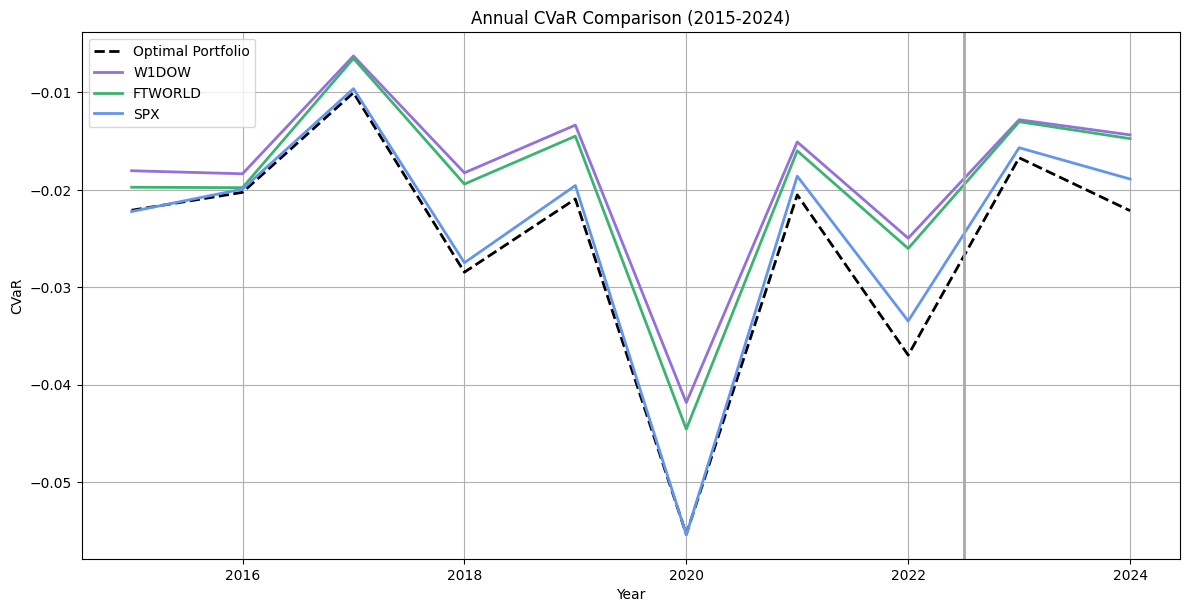

In [ ]:
# Compute returns and CVaR for 2015-2024
portfolio_cvar = compute_portfolio_values(fixed_weights, annual_cvar, range(2015, 2025))

# Extract benchmark values
excluded_assets_cvar = {asset: [annual_cvar[asset][year - 2015] for year in range(2015, 2025)] for asset in EXCLUDED_ASSETS}

# Plot results
plot_results(portfolio_cvar, excluded_assets_cvar, range(2015, 2025), "CVaR", "Annual CVaR Comparison (2015-2024)")

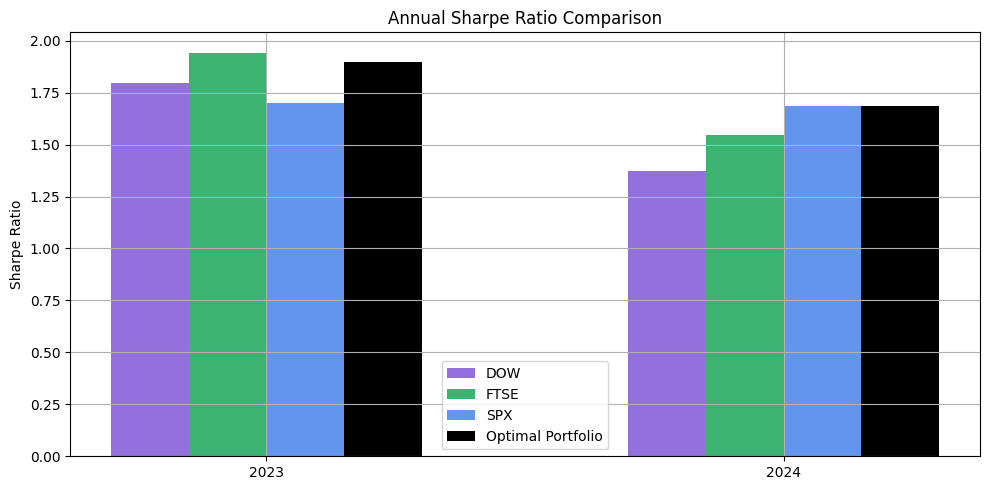

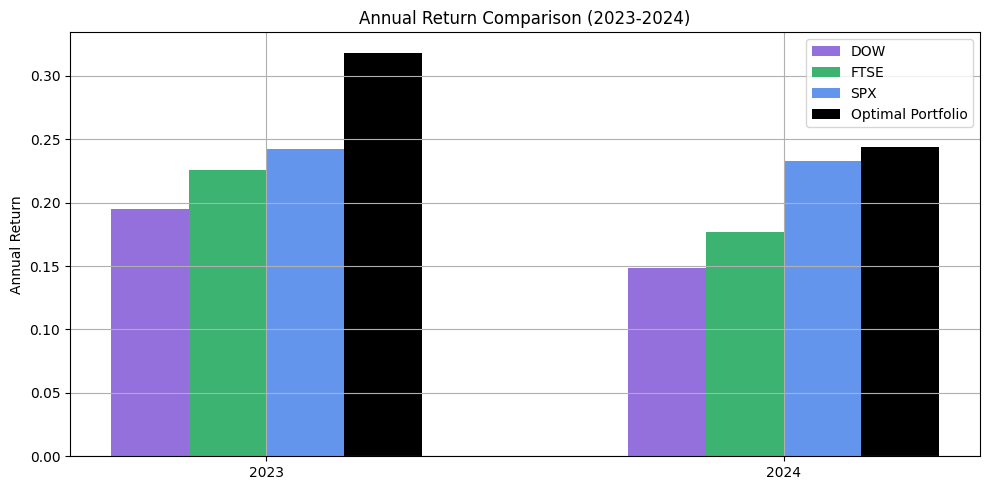

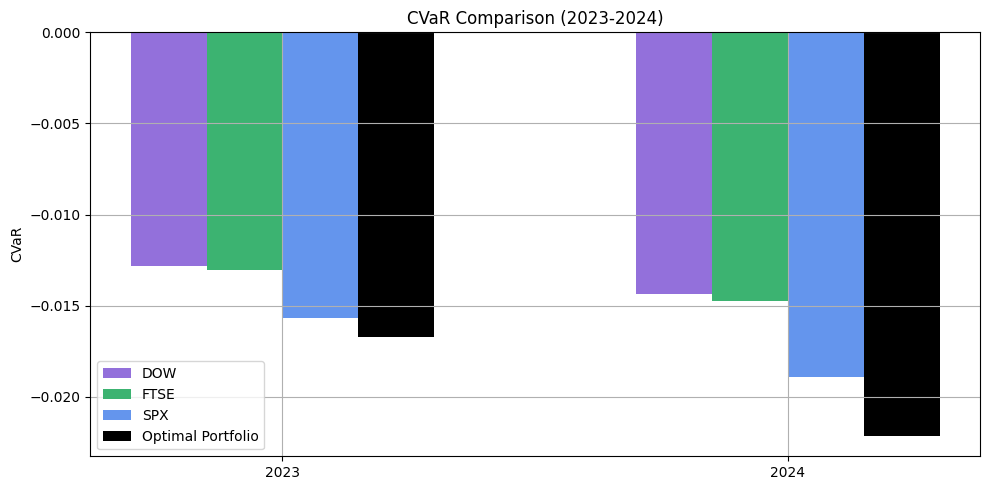

In [ ]:
# Function to compute Sharpe Ratio
def compute_sharpe_ratio(returns, volatilities, risk_free_rate=0.02):
    return [(r - risk_free_rate) / v if v != 0 else None for r, v in zip(returns, volatilities)]

# Function to plot bar charts
def plot_bar_charts(portfolio_values, excluded_assets_values, years, ylabel, title):
    x = np.arange(len(years))
    bar_width = 0.15

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(x - bar_width * 1.5, excluded_assets_values["W1DOW"], bar_width, label="DOW", color="mediumpurple")
    ax.bar(x - bar_width * 0.5, excluded_assets_values["FTWORLD"], bar_width, label="FTSE", color="mediumseagreen")
    ax.bar(x + bar_width * 0.5, excluded_assets_values["SPX"], bar_width, label="SPX", color="cornflowerblue")
    ax.bar(x + bar_width * 1.5, portfolio_values, bar_width, label="Optimal Portfolio", color="black")

    ax.set_xticks(x)
    ax.set_xticklabels(years)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Compute returns, volatility, and Sharpe Ratio for 2015-2024
portfolio_returns = compute_portfolio_values(fixed_weights, annual_returns, range(2023, 2025))
portfolio_cvar = compute_portfolio_values(fixed_weights, annual_cvar, range(2023, 2025))
portfolio_sharpe = compute_sharpe_ratio(portfolio_returns, portfolio_vol)

# Extract benchmark values for 2015-2024
excluded_assets_returns = {asset: [annual_returns[asset][year - 2015] for year in range(2023, 2025)] for asset in EXCLUDED_ASSETS}
excluded_assets_cvar = {asset: [annual_cvar[asset][year - 2015] for year in range(2023, 2025)] for asset in EXCLUDED_ASSETS}
excluded_assets_vol = {asset: [annual_vol[asset][year - 2015] for year in range(2023, 2025)] for asset in EXCLUDED_ASSETS}
excluded_assets_sharpe = {asset: compute_sharpe_ratio(excluded_assets_returns[asset], excluded_assets_vol[asset]) for asset in EXCLUDED_ASSETS}

# Plot bar charts
plot_bar_charts(portfolio_sharpe, excluded_assets_sharpe, range(2023, 2025), "Sharpe Ratio", "Annual Sharpe Ratio Comparison")
plot_bar_charts(portfolio_returns, excluded_assets_returns, [2023, 2024], "Annual Return", "Annual Return Comparison (2023-2024)")
plot_bar_charts(portfolio_cvar, excluded_assets_cvar, [2023, 2024], "CVaR", "CVaR Comparison (2023-2024)")

# **Multi-Objective Portfolio Optimization**

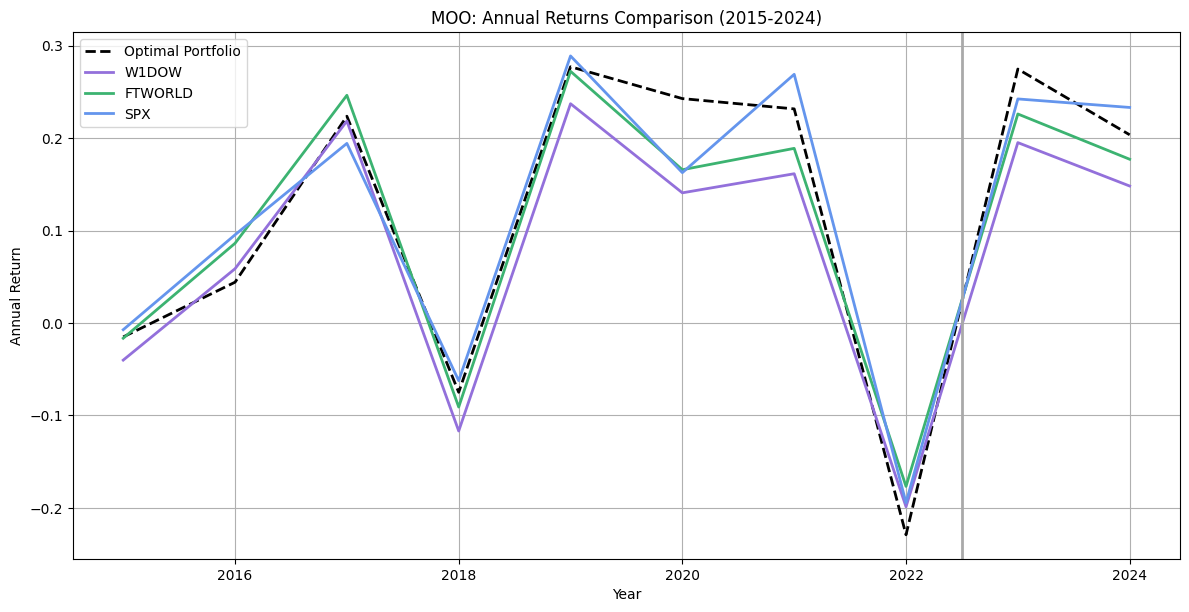

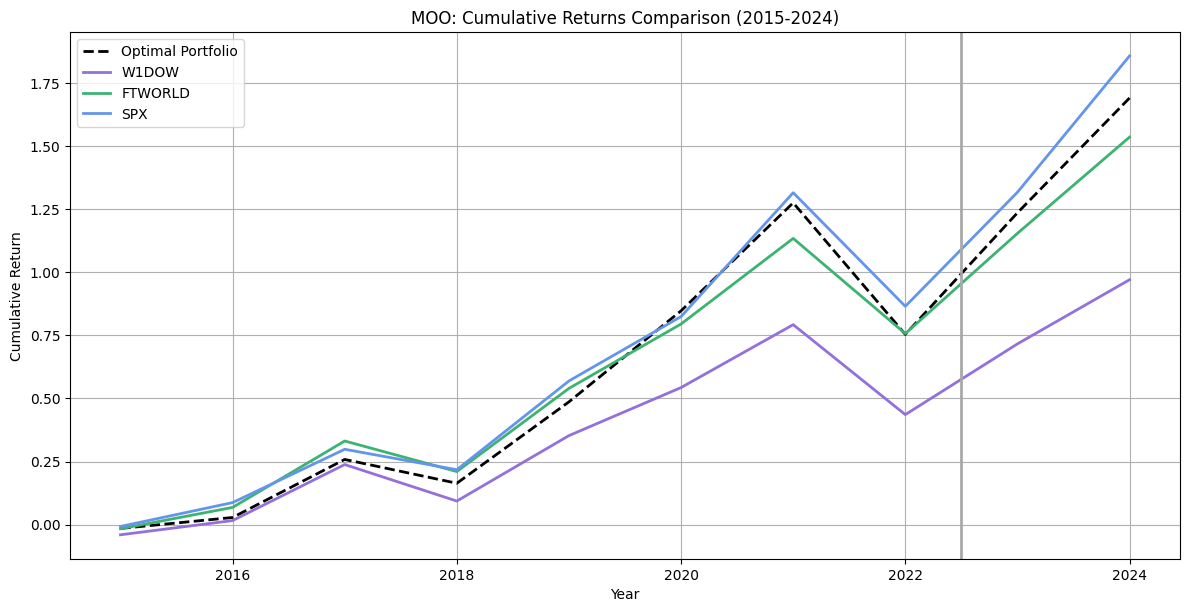

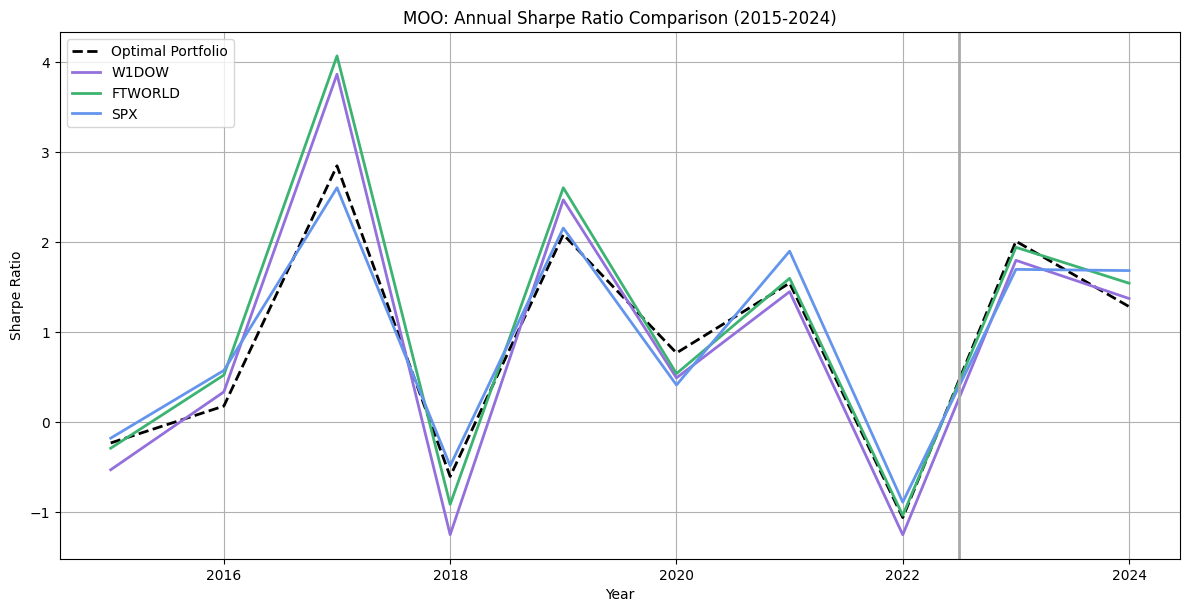

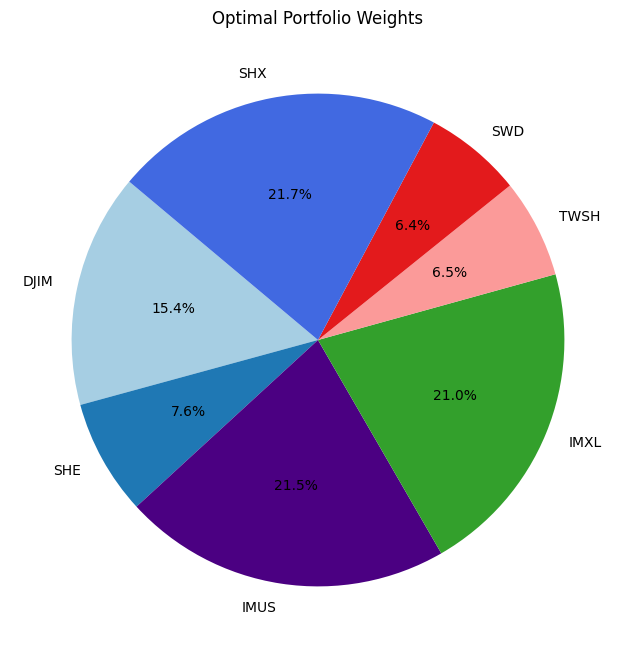

In [ ]:
# Define excluded assets
EXCLUDED_ASSETS = ["W1DOW", "FTWORLD", "SPX"]

# Function to calculate annual metrics
def calculate_annual_metrics_moo(file_paths):
    annual_returns, annual_vol, annual_cvar = {}, {}, {}
    start_year, end_year = 2015, 2024

    for file_path in file_paths:
        df = pd.read_excel(file_path)
        file_name = os.path.splitext(os.path.basename(file_path))[0]
        date_column, price_column = df.columns[0], df.columns[1]
        df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
        df[price_column] = pd.to_numeric(df[price_column], errors='coerce')
        df.dropna(subset=[date_column, price_column], inplace=True)
        df.sort_values(by=date_column, inplace=True)
        df['Returns'] = df[price_column].pct_change()

        yearly_returns, yearly_vol, yearly_cvar = [], [], []
        for year in range(start_year, end_year + 1):
            yearly_data = df[df[date_column].dt.year == year]['Returns'].dropna()
            if not yearly_data.empty:
                yearly_returns.append((yearly_data + 1).prod() - 1)
                yearly_vol.append(yearly_data.std() * np.sqrt(252))
                var_95 = yearly_data.quantile(0.05)
                yearly_cvar.append(yearly_data[yearly_data <= var_95].mean())
            else:
                yearly_returns.append(None)
                yearly_vol.append(None)
                yearly_cvar.append(None)

        annual_returns[file_name] = yearly_returns
        annual_vol[file_name] = yearly_vol
        annual_cvar[file_name] = yearly_cvar

    return annual_returns, annual_vol, annual_cvar

# Function to optimize portfolio weights using MOO
def optimize_portfolio_moo(annual_returns, annual_vol, annual_cvar):
    relevant_assets = [asset for asset in annual_returns.keys() if asset not in EXCLUDED_ASSETS]
    num_assets = len(relevant_assets)
    avg_returns = np.mean([
        [annual_returns[asset][year - 2015] for year in range(2015, 2023)]
        for asset in relevant_assets
    ], axis=1)
    avg_vols = np.mean([
        [annual_vol[asset][year - 2015] for year in range(2015, 2023)]
        for asset in relevant_assets
    ], axis=1)
    avg_cvar = np.mean([
        [annual_cvar[asset][year - 2015] for year in range(2015, 2023)]
        for asset in relevant_assets
    ], axis=1)

    def objective(w):
        return -np.dot(w, avg_returns) + np.dot(w**2, avg_vols) + np.dot(w, avg_cvar)

    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'ineq', 'fun': lambda w: np.dot(w, avg_returns) - 0.05}  # Minimum return constraint
    ]

    bounds = [(0, 0.5) for _ in range(num_assets)]
    initial_weights = np.ones(num_assets) / num_assets
    result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)
    return dict(zip(relevant_assets, result.x))

# Function to plot pie chart of portfolio weights
def plot_portfolio_weights(weights):
    categorized_weights = {k: v for k, v in weights.items() if v >= 0.05}
    other_weight = sum(v for k, v in weights.items() if v < 0.0005)
    if other_weight > 0:
        categorized_weights["Other"] = other_weight

    labels = [k if v >= 0.05 else "" for k, v in categorized_weights.items()]
    sizes = list(categorized_weights.values())
    colors = ["royalblue" if k == "SHX" else "indigo" if k == "IMUS" else c
              for k, c in zip(labels, plt.cm.Paired.colors)]

    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct=lambda p: f'{p:.1f}%' if p > 5 else '',
            startangle=140, colors=colors)
    plt.title("Optimal Portfolio Weights")
    plt.show()

# Main execution
annual_returns, annual_vol, annual_cvar = calculate_annual_metrics_moo(file_paths)
fixed_weights_moo = optimize_portfolio_moo(annual_returns, annual_vol, annual_cvar)

# Compute portfolio performance
portfolio_returns_moo = compute_portfolio_values(fixed_weights_moo, annual_returns, range(2015, 2025))
portfolio_vol_moo = compute_portfolio_values(fixed_weights_moo, annual_vol, range(2015, 2025))
portfolio_cvar_moo = compute_portfolio_values(fixed_weights_moo, annual_cvar, range(2015, 2025))
portfolio_sharpe_moo = compute_sharpe_ratio(portfolio_returns_moo, portfolio_vol_moo)
portfolio_cumulative_returns_moo = calculate_cumulative_returns(portfolio_returns_moo)

# Extract benchmark values
excluded_assets_cumulative_returns_moo = {asset: calculate_cumulative_returns([annual_returns[asset][year - 2015] for year in range(2015, 2025)]) for asset in EXCLUDED_ASSETS}

# Plot results for MOO formulation
plot_results(portfolio_returns_moo, {asset: [annual_returns[asset][year - 2015] for year in range(2015, 2025)] for asset in EXCLUDED_ASSETS}, range(2015, 2025), "Annual Return", "MOO: Annual Returns Comparison (2015-2024)")
plot_results(portfolio_cumulative_returns_moo, excluded_assets_cumulative_returns_moo, range(2015, 2025), "Cumulative Return", "MOO: Cumulative Returns Comparison (2015-2024)")
plot_results(portfolio_sharpe_moo, {asset: compute_sharpe_ratio([annual_returns[asset][year - 2015] for year in range(2015, 2025)], [annual_vol[asset][year - 2015] for year in range(2015, 2025)]) for asset in EXCLUDED_ASSETS}, range(2015, 2025), "Sharpe Ratio", "MOO: Annual Sharpe Ratio Comparison (2015-2024)")

# Plot portfolio weights for MOO
plot_portfolio_weights(fixed_weights_moo)


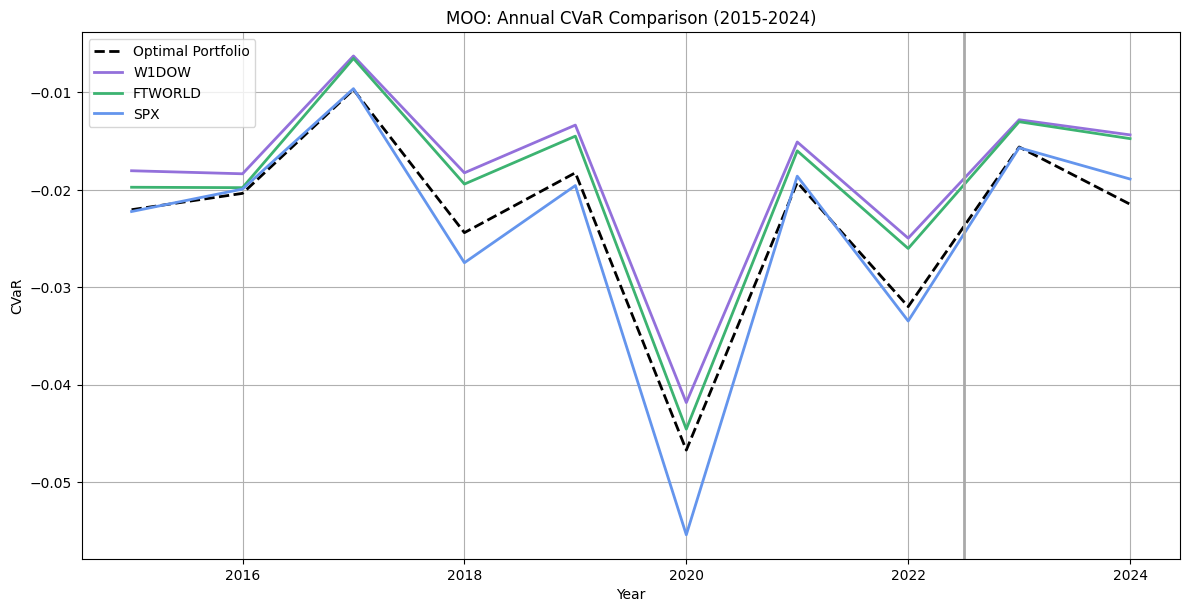

In [ ]:
# Define excluded assets
EXCLUDED_ASSETS = ["W1DOW", "FTWORLD", "SPX"]

# Main execution
annual_returns, annual_vol, annual_cvar = calculate_annual_metrics_moo(file_paths)
fixed_weights_moo = optimize_portfolio_moo(annual_returns, annual_vol, annual_cvar)

# Compute portfolio performance
portfolio_cvar_moo = compute_portfolio_values(fixed_weights_moo, annual_cvar, range(2015, 2025))
excluded_assets_cvar_moo = {asset: [annual_cvar[asset][year - 2015] for year in range(2015, 2025)] for asset in EXCLUDED_ASSETS}
plot_results(portfolio_cvar_moo, excluded_assets_cvar_moo, range(2015, 2025), "CVaR", "MOO: Annual CVaR Comparison (2015-2024)")

In [ ]:
# Function to plot bar charts
def plot_bar_charts_moo(portfolio_values, excluded_assets_values, years, ylabel, title):
    x = np.arange(len(years))
    bar_width = 0.15

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(x - bar_width * 1.5, excluded_assets_values["W1DOW"], bar_width, label="DOW", color="mediumpurple")
    ax.bar(x - bar_width * 0.5, excluded_assets_values["FTWORLD"], bar_width, label="FTSE", color="mediumseagreen")
    ax.bar(x + bar_width * 0.5, excluded_assets_values["SPX"], bar_width, label="SPX", color="cornflowerblue")
    ax.bar(x + bar_width * 1.5, portfolio_values, bar_width, label="Optimal Portfolio", color="black")

    ax.set_xticks(x)
    ax.set_xticklabels(years)
    ax.set_ylabel(ylabel)
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

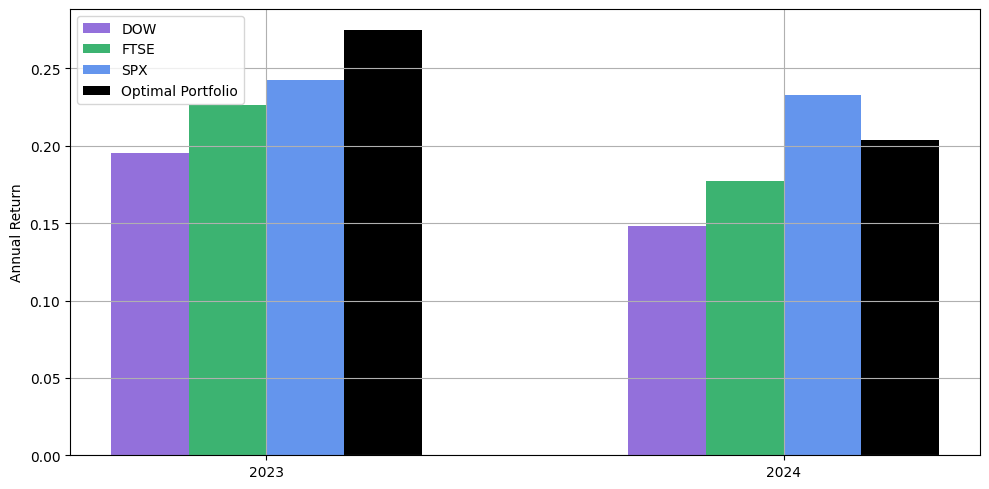

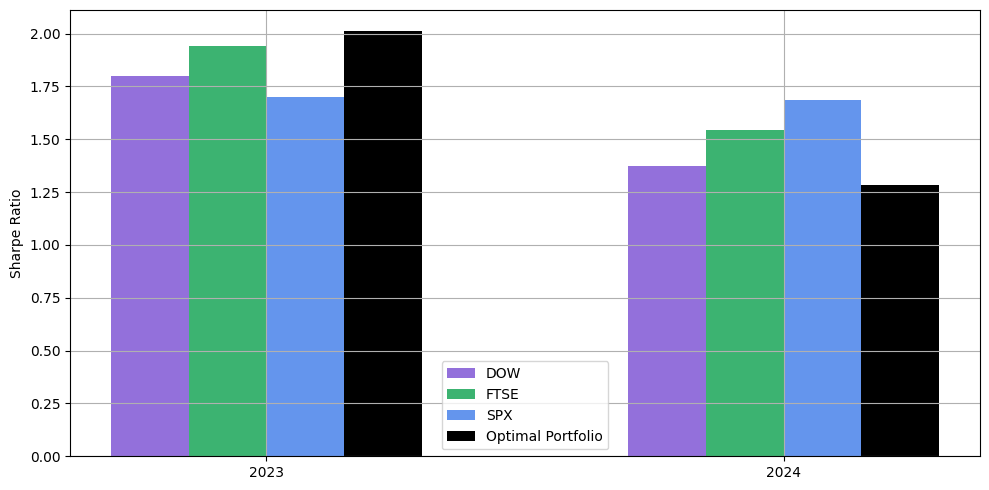

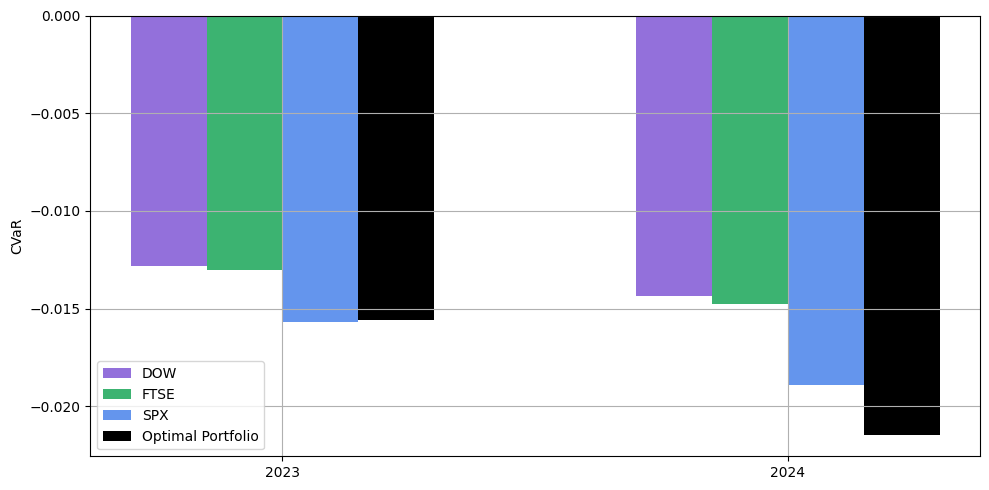

In [ ]:
# Define excluded assets
EXCLUDED_ASSETS = ["W1DOW", "FTWORLD", "SPX"]

# Compute portfolio performance for 2023-2024
portfolio_returns_moo = compute_portfolio_values(fixed_weights_moo, annual_returns, range(2023, 2025))
portfolio_vol_moo = compute_portfolio_values(fixed_weights_moo, annual_vol, range(2023, 2025))
portfolio_cvar_moo = compute_portfolio_values(fixed_weights_moo, annual_cvar, range(2023, 2025))
portfolio_sharpe_moo = compute_sharpe_ratio(portfolio_returns_moo, portfolio_vol_moo)

# Extract benchmark values for 2023-2024
excluded_assets_returns_moo = {asset: [annual_returns[asset][year - 2015] for year in range(2023, 2025)] for asset in EXCLUDED_ASSETS}
excluded_assets_vol_moo = {asset: [annual_vol[asset][year - 2015] for year in range(2023, 2025)] for asset in EXCLUDED_ASSETS}
excluded_assets_cvar_moo = {asset: [annual_cvar[asset][year - 2015] for year in range(2023, 2025)] for asset in EXCLUDED_ASSETS}
excluded_assets_sharpe_moo = {asset: compute_sharpe_ratio(excluded_assets_returns_moo[asset], excluded_assets_vol_moo[asset]) for asset in EXCLUDED_ASSETS}

# Plot results for 2023-2024
plot_bar_charts_moo(portfolio_returns_moo, excluded_assets_returns_moo, [2023, 2024], "Annual Return", "MOO: Annual Return Comparison (2023-2024)")
plot_bar_charts_moo(portfolio_sharpe_moo, excluded_assets_sharpe_moo, [2023, 2024], "Sharpe Ratio", "MOO: Annual Sharpe Ratio Comparison (2023-2024)")
plot_bar_charts_moo(portfolio_cvar_moo, excluded_assets_cvar_moo, [2023, 2024], "CVaR", "MOO: CVaR Comparison (2023-2024)")

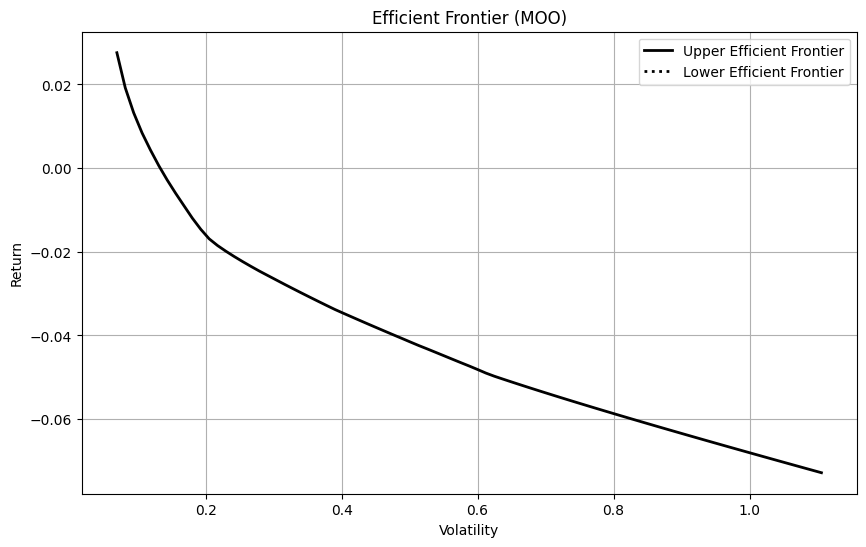

In [ ]:
# Define excluded assets
EXCLUDED_ASSETS = ["W1DOW", "FTWORLD", "SPX"]

# Function to compute the efficient frontier using multi-objective optimization
def compute_efficient_frontier_moo(annual_returns, annual_vol, annual_cvar):
    relevant_assets = [asset for asset in annual_returns.keys() if asset not in EXCLUDED_ASSETS]
    num_assets = len(relevant_assets)
    avg_returns = np.array([np.mean(annual_returns[asset][:9]) for asset in relevant_assets])  # 2015-2023 data
    avg_vols = np.array([np.mean(annual_vol[asset][:9]) for asset in relevant_assets])
    avg_cvar = np.array([np.mean(annual_cvar[asset][:9]) for asset in relevant_assets])

    risk_levels = np.linspace(min(avg_vols), max(avg_vols), 100)
    efficient_portfolios = []

    for risk_target in risk_levels:
        def objective(w):
            return np.dot(w, avg_returns) + np.dot(w**2, avg_vols) + np.dot(w, avg_cvar)

        constraints = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # Fully invested constraint
            {'type': 'eq', 'fun': lambda w: np.sqrt(np.dot(w.T, np.dot(np.diag(avg_vols), w))) - risk_target}  # Risk constraint
        ]

        bounds = [(0, 1) for _ in range(num_assets)]
        initial_weights = np.ones(num_assets) / num_assets
        result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints, method='SLSQP')

        if result.success:
            portfolio_return = np.dot(result.x, avg_returns)
            portfolio_volatility = np.sqrt(np.dot(result.x.T, np.dot(np.diag(avg_vols), result.x)))
            efficient_portfolios.append((portfolio_volatility, portfolio_return))

    efficient_portfolios = np.array(efficient_portfolios)
    efficient_portfolios = efficient_portfolios[np.argsort(efficient_portfolios[:, 0])]  # Sort by volatility

    # Extract only the upper and lower envelope (efficient frontier)
    upper_frontier = []
    lower_frontier = []
    max_return = -np.inf
    min_return = np.inf

    for vol, ret in efficient_portfolios[::-1]:  # Traverse from highest return
        if ret > max_return:
            upper_frontier.append((vol, ret))
            max_return = ret
        if ret < min_return:
            lower_frontier.append((vol, ret))
            min_return = ret

    upper_frontier = np.array(upper_frontier[::-1])  # Reverse to maintain increasing order of volatility
    lower_frontier = np.array(lower_frontier)

    return upper_frontier, lower_frontier

# Function to plot efficient frontier
def plot_efficient_frontier(upper_frontier, lower_frontier):
    plt.figure(figsize=(10, 6))
    plt.plot(upper_frontier[:, 0], upper_frontier[:, 1], color='black', linewidth=2, label='Upper Efficient Frontier')
    plt.plot(lower_frontier[:, 0], lower_frontier[:, 1], color='black', linewidth=2, linestyle='dotted', label='Lower Efficient Frontier')
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.title('Efficient Frontier (MOO)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Compute and plot the efficient frontier for MOO formulation
upper_frontier, lower_frontier = compute_efficient_frontier_moo(annual_returns, annual_vol, annual_cvar)
plot_efficient_frontier(upper_frontier, lower_frontier)

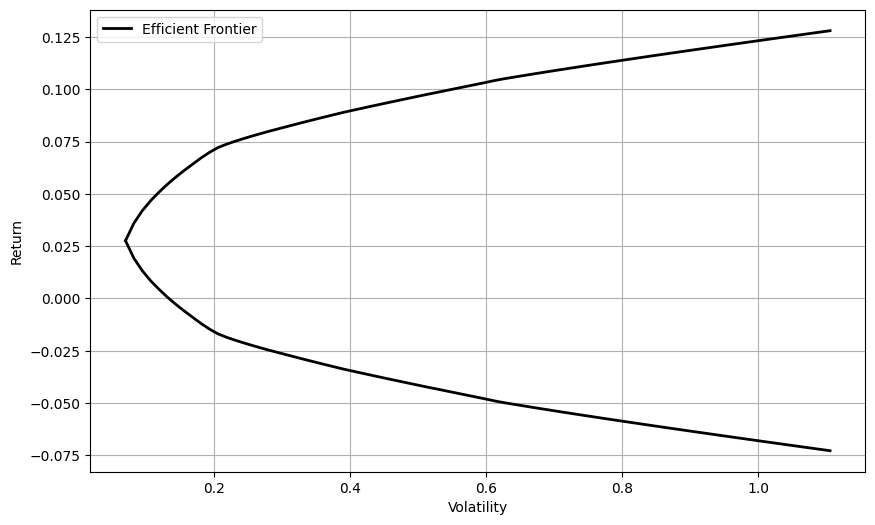

In [ ]:
# Define excluded assets
EXCLUDED_ASSETS = ["W1DOW", "FTWORLD", "SPX"]

# Function to compute the efficient frontier using multi-objective optimization
def compute_efficient_frontier_moo(annual_returns, annual_vol, annual_cvar):
    relevant_assets = [asset for asset in annual_returns.keys() if asset not in EXCLUDED_ASSETS]
    num_assets = len(relevant_assets)
    avg_returns = np.array([np.mean(annual_returns[asset][:9]) for asset in relevant_assets])  # 2015-2023 data
    avg_vols = np.array([np.mean(annual_vol[asset][:9]) for asset in relevant_assets])
    avg_cvar = np.array([np.mean(annual_cvar[asset][:9]) for asset in relevant_assets])

    risk_levels = np.linspace(min(avg_vols), max(avg_vols), 100)
    efficient_portfolios = []

    for risk_target in risk_levels:
        def objective(w):
            return np.dot(w, avg_returns) + np.dot(w**2, avg_vols) + np.dot(w, avg_cvar)

        constraints = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # Fully invested constraint
            {'type': 'eq', 'fun': lambda w: np.sqrt(np.dot(w.T, np.dot(np.diag(avg_vols), w))) - risk_target}  # Risk constraint
        ]

        bounds = [(0, 1) for _ in range(num_assets)]
        initial_weights = np.ones(num_assets) / num_assets
        result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints, method='SLSQP')

        if result.success:
            portfolio_return = np.dot(result.x, avg_returns)
            portfolio_volatility = np.sqrt(np.dot(result.x.T, np.dot(np.diag(avg_vols), result.x)))
            efficient_portfolios.append((portfolio_volatility, portfolio_return))

    efficient_portfolios = np.array(efficient_portfolios)
    efficient_portfolios = efficient_portfolios[np.argsort(efficient_portfolios[:, 0])]  # Sort by volatility

    # Extract lower envelope (efficient frontier) and mirror it for upper frontier at max return value
    lower_frontier = efficient_portfolios
    max_return = np.max(lower_frontier[:, 1])
    upper_frontier = np.copy(lower_frontier)
    upper_frontier[:, 1] = 2 * max_return - upper_frontier[:, 1]  # Flip over the max return value

    return upper_frontier, lower_frontier

# Function to plot efficient frontier
def plot_efficient_frontier(upper_frontier, lower_frontier):
    plt.figure(figsize=(10, 6))
    plt.plot(upper_frontier[:, 0], upper_frontier[:, 1], color='black', linewidth=2, label='Efficient Frontier')
    plt.plot(lower_frontier[:, 0], lower_frontier[:, 1], color='black', linewidth=2)
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.legend()
    plt.grid(True)
    plt.show()

# Compute and plot the efficient frontier for MOO formulation
upper_frontier, lower_frontier = compute_efficient_frontier_moo(annual_returns, annual_vol, annual_cvar)
plot_efficient_frontier(upper_frontier, lower_frontier)

# Multi-Objective without Min Return

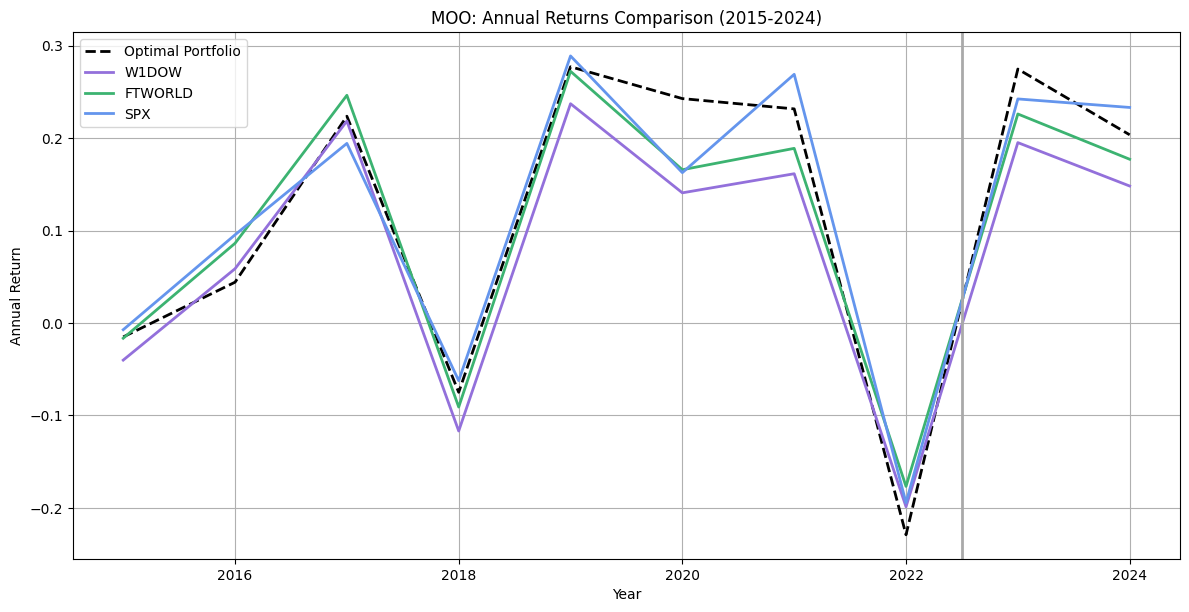

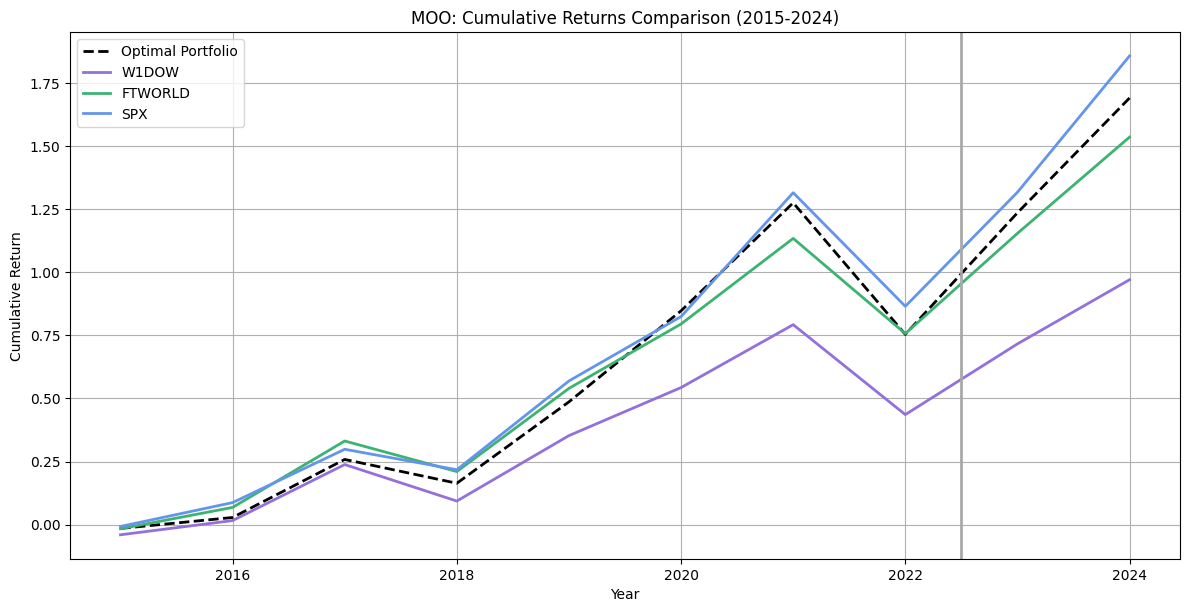

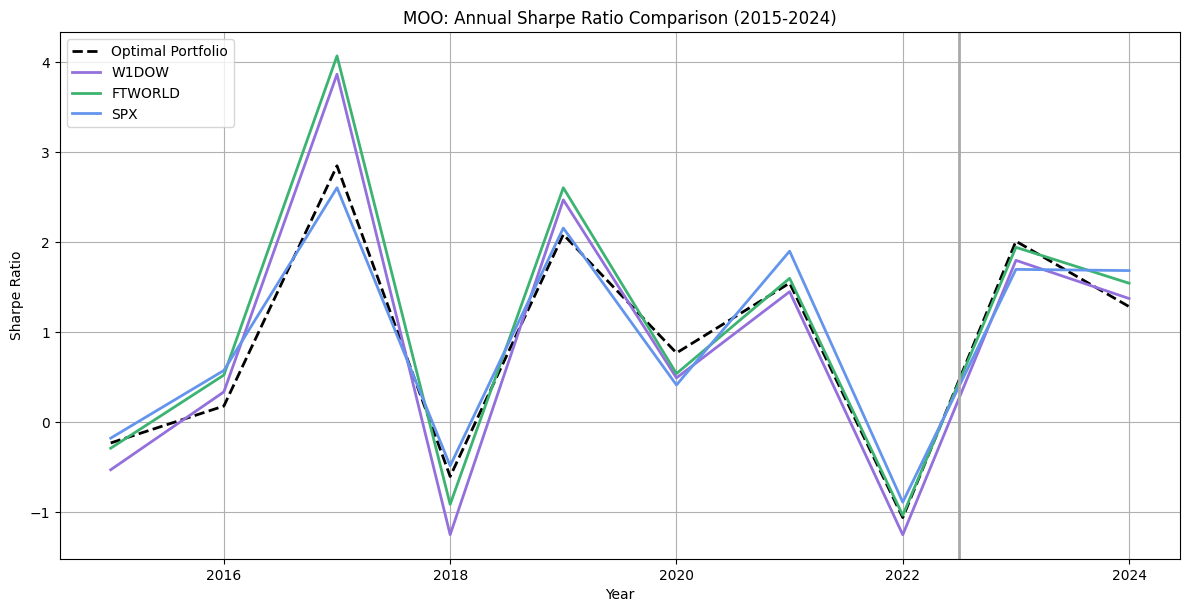

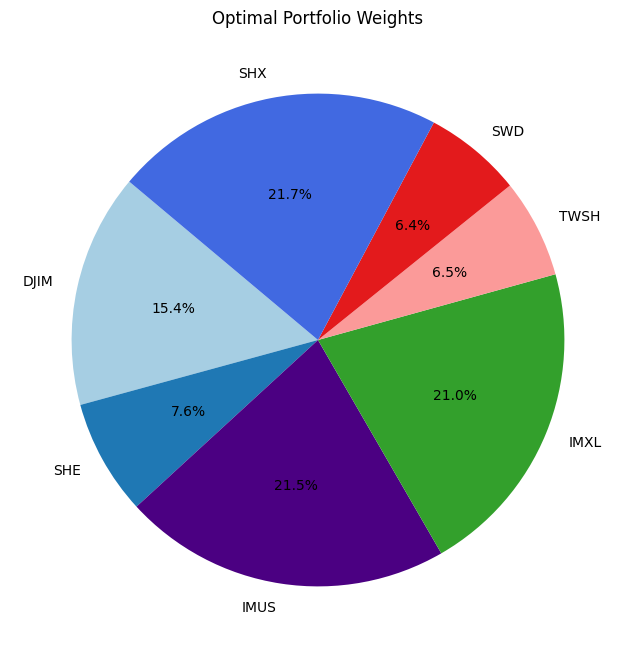

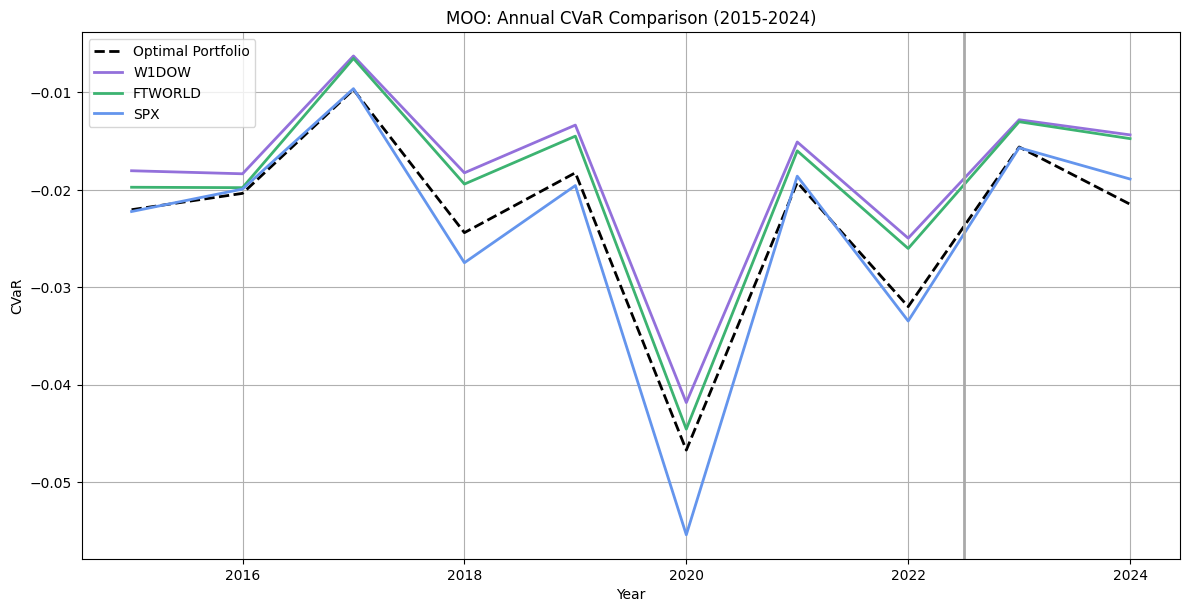

In [ ]:
# Define excluded assets
EXCLUDED_ASSETS = ["W1DOW", "FTWORLD", "SPX"]

# Function to calculate annual metrics
def calculate_annual_metrics_moo(file_paths):
    annual_returns, annual_vol, annual_cvar = {}, {}, {}
    start_year, end_year = 2015, 2024

    for file_path in file_paths:
        df = pd.read_excel(file_path)
        file_name = os.path.splitext(os.path.basename(file_path))[0]
        date_column, price_column = df.columns[0], df.columns[1]
        df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
        df[price_column] = pd.to_numeric(df[price_column], errors='coerce')
        df.dropna(subset=[date_column, price_column], inplace=True)
        df.sort_values(by=date_column, inplace=True)
        df['Returns'] = df[price_column].pct_change()

        yearly_returns, yearly_vol, yearly_cvar = [], [], []
        for year in range(start_year, end_year + 1):
            yearly_data = df[df[date_column].dt.year == year]['Returns'].dropna()
            if not yearly_data.empty:
                yearly_returns.append((yearly_data + 1).prod() - 1)
                yearly_vol.append(yearly_data.std() * np.sqrt(252))
                var_95 = yearly_data.quantile(0.05)
                yearly_cvar.append(yearly_data[yearly_data <= var_95].mean())
            else:
                yearly_returns.append(None)
                yearly_vol.append(None)
                yearly_cvar.append(None)

        annual_returns[file_name] = yearly_returns
        annual_vol[file_name] = yearly_vol
        annual_cvar[file_name] = yearly_cvar

    return annual_returns, annual_vol, annual_cvar

# Function to optimize portfolio weights using MOO
def optimize_portfolio_moo(annual_returns, annual_vol, annual_cvar):
    relevant_assets = [asset for asset in annual_returns.keys() if asset not in EXCLUDED_ASSETS]
    num_assets = len(relevant_assets)
    avg_returns = np.mean([
        [annual_returns[asset][year - 2015] for year in range(2015, 2023)]
        for asset in relevant_assets
    ], axis=1)
    avg_vols = np.mean([
        [annual_vol[asset][year - 2015] for year in range(2015, 2023)]
        for asset in relevant_assets
    ], axis=1)
    avg_cvar = np.mean([
        [annual_cvar[asset][year - 2015] for year in range(2015, 2023)]
        for asset in relevant_assets
    ], axis=1)

    def objective(w):
        return -np.dot(w, avg_returns) + np.dot(w**2, avg_vols) + np.dot(w, avg_cvar)

    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
    ]

    bounds = [(0, 0.5) for _ in range(num_assets)]
    initial_weights = np.ones(num_assets) / num_assets
    result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)
    return dict(zip(relevant_assets, result.x))

# Function to plot pie chart of portfolio weights
def plot_portfolio_weights(weights):
    categorized_weights = {k: v for k, v in weights.items() if v >= 0.05}
    other_weight = sum(v for k, v in weights.items() if v < 0.0005)
    if other_weight > 0:
        categorized_weights["Other"] = other_weight

    labels = [k if v >= 0.05 else "" for k, v in categorized_weights.items()]
    sizes = list(categorized_weights.values())
    colors = ["royalblue" if k == "SHX" else "indigo" if k == "IMUS" else c
              for k, c in zip(labels, plt.cm.Paired.colors)]

    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct=lambda p: f'{p:.1f}%' if p > 5 else '',
            startangle=140, colors=colors)
    plt.title("Optimal Portfolio Weights")
    plt.show()

# Main execution
annual_returns, annual_vol, annual_cvar = calculate_annual_metrics_moo(file_paths)
fixed_weights_moo = optimize_portfolio_moo(annual_returns, annual_vol, annual_cvar)

# Compute portfolio performance
portfolio_returns_moo = compute_portfolio_values(fixed_weights_moo, annual_returns, range(2015, 2025))
portfolio_vol_moo = compute_portfolio_values(fixed_weights_moo, annual_vol, range(2015, 2025))
portfolio_cvar_moo = compute_portfolio_values(fixed_weights_moo, annual_cvar, range(2015, 2025))
portfolio_sharpe_moo = compute_sharpe_ratio(portfolio_returns_moo, portfolio_vol_moo)
portfolio_cumulative_returns_moo = calculate_cumulative_returns(portfolio_returns_moo)

# Extract benchmark values
excluded_assets_cumulative_returns_moo = {asset: calculate_cumulative_returns([annual_returns[asset][year - 2015] for year in range(2015, 2025)]) for asset in EXCLUDED_ASSETS}

# Plot results for MOO formulation
plot_results(portfolio_returns_moo, {asset: [annual_returns[asset][year - 2015] for year in range(2015, 2025)] for asset in EXCLUDED_ASSETS}, range(2015, 2025), "Annual Return", "MOO: Annual Returns Comparison (2015-2024)")
plot_results(portfolio_cumulative_returns_moo, excluded_assets_cumulative_returns_moo, range(2015, 2025), "Cumulative Return", "MOO: Cumulative Returns Comparison (2015-2024)")
plot_results(portfolio_sharpe_moo, {asset: compute_sharpe_ratio([annual_returns[asset][year - 2015] for year in range(2015, 2025)], [annual_vol[asset][year - 2015] for year in range(2015, 2025)]) for asset in EXCLUDED_ASSETS}, range(2015, 2025), "Sharpe Ratio", "MOO: Annual Sharpe Ratio Comparison (2015-2024)")

# Plot portfolio weights for MOO
plot_portfolio_weights(fixed_weights_moo)

# Compute portfolio performance
excluded_assets_cvar_moo = {asset: [annual_cvar[asset][year - 2015] for year in range(2015, 2025)] for asset in EXCLUDED_ASSETS}
plot_results(portfolio_cvar_moo, excluded_assets_cvar_moo, range(2015, 2025), "CVaR", "MOO: Annual CVaR Comparison (2015-2024)")

# Extract benchmark values for 2023-2024
excluded_assets_returns_moo = {asset: [annual_returns[asset][year - 2015] for year in range(2023, 2025)] for asset in EXCLUDED_ASSETS}
excluded_assets_vol_moo = {asset: [annual_vol[asset][year - 2015] for year in range(2023, 2025)] for asset in EXCLUDED_ASSETS}
excluded_assets_cvar_moo = {asset: [annual_cvar[asset][year - 2015] for year in range(2023, 2025)] for asset in EXCLUDED_ASSETS}
excluded_assets_sharpe_moo = {asset: compute_sharpe_ratio(excluded_assets_returns_moo[asset], excluded_assets_vol_moo[asset]) for asset in EXCLUDED_ASSETS}

# Quantitative Metrics for **Sector Indices**

In [ ]:
# Specify the folder path
folder_path = '/content/drive/My Drive/Thesis/Sectors'

# List all files in the folder
file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.xlsx')]

In [ ]:
print("File paths:", file_paths)

File paths: ['/content/drive/My Drive/Thesis/Sectors/USBC.xlsx', '/content/drive/My Drive/Thesis/Sectors/IUTI.xlsx', '/content/drive/My Drive/Thesis/Sectors/USEN.xlsx', '/content/drive/My Drive/Thesis/Sectors/USHC.xlsx', '/content/drive/My Drive/Thesis/Sectors/USFN.xlsx', '/content/drive/My Drive/Thesis/Sectors/USIN.xlsx', '/content/drive/My Drive/Thesis/Sectors/USNC.xlsx', '/content/drive/My Drive/Thesis/Sectors/USTC.xlsx', '/content/drive/My Drive/Thesis/Sectors/USUT.xlsx', '/content/drive/My Drive/Thesis/Sectors/IENE.xlsx', '/content/drive/My Drive/Thesis/Sectors/IHCR.xlsx', '/content/drive/My Drive/Thesis/Sectors/IFIN.xlsx', '/content/drive/My Drive/Thesis/Sectors/IIDU.xlsx', '/content/drive/My Drive/Thesis/Sectors/INCY.xlsx', '/content/drive/My Drive/Thesis/Sectors/ISBC.xlsx', '/content/drive/My Drive/Thesis/Sectors/IUIM.xlsx', '/content/drive/My Drive/Thesis/Sectors/W1DOW.xlsx']


In [ ]:
def calculate_annual_metrics(file_paths):
    annual_returns = {}
    annual_vol = {}
    annual_var = {}
    annual_cvar = {}

    start_year = 2015
    end_year = 2024

    for file_path in file_paths:
        # Load the Excel file
        df = pd.read_excel(file_path)

        # Extract file name without extension
        file_name = os.path.splitext(os.path.basename(file_path))[0]

        # Convert the first column to datetime, handling errors
        date_column = df.columns[0]
        df[date_column] = pd.to_datetime(df[date_column], format='%m/%d/%Y', errors='coerce')

        # Ensure the second column (closing prices) is numeric
        price_column = df.columns[1]
        df[price_column] = pd.to_numeric(df[price_column], errors='coerce')

        # Drop rows with NaN values in either column
        df.dropna(subset=[date_column, price_column], inplace=True)-

        # Sort by date in case the data isn't ordered
        df.sort_values(by=date_column, inplace=True)

        # Calculate daily returns
        df['Returns'] = df[price_column].pct_change()

        # Initialize lists for storing yearly metrics
        yearly_returns = []
        yearly_vol = []
        yearly_var = []
        yearly_cvar = []

        for year in range(start_year, end_year + 1):
            yearly_data = df[df[date_column].dt.year == year]['Returns'].dropna()

            if not yearly_data.empty:
                # Annual Return
                yearly_returns.append((yearly_data + 1).prod() - 1)

                # Annual Volatility (Standard deviation of daily returns scaled to annual)
                yearly_vol.append(yearly_data.std() * np.sqrt(252))

                # Value at Risk (VaR) at 95% confidence level
                var_95 = yearly_data.quantile(0.05)
                yearly_var.append(var_95)

                # Conditional Value at Risk (CVaR) - Expected Shortfall at 95%
                cvar_95 = yearly_data[yearly_data <= var_95].mean()
                yearly_cvar.append(cvar_95)
            else:
                yearly_returns.append(None)
                yearly_vol.append(None)
                yearly_var.append(None)
                yearly_cvar.append(None)

        # Store the results
        annual_returns[file_name] = yearly_returns
        annual_vol[file_name] = yearly_vol
        annual_var[file_name] = yearly_var
        annual_cvar[file_name] = yearly_cvar

    # Sort results alphabetically by file_name
    annual_returns = dict(sorted(annual_returns.items()))
    annual_vol = dict(sorted(annual_vol.items()))
    annual_var = dict(sorted(annual_var.items()))
    annual_cvar = dict(sorted(annual_cvar.items()))

    return annual_returns, annual_vol, annual_var, annual_cvar

In [ ]:
# Calculate metrics
sector_ann_return, sector_ann_vol, sector_ann_var, sector_ann_cvar = calculate_annual_metrics(file_paths)

In [ ]:
def plot_annual_returns_heatmap(annual_returns):
    # Convert the dictionary to a DataFrame
    years = list(range(2015, 2025))
    annual_returns_df = pd.DataFrame(annual_returns, index=years)

    # Rename specific indices and move them to the front
    rename_dict = {"W1DOW": "DOW (Con.)"}
    annual_returns_df = annual_returns_df.rename(columns=rename_dict)
    column_order = [col for col in rename_dict.values() if col in annual_returns_df.columns] + [col for col in annual_returns_df.columns if col not in rename_dict.values()]
    annual_returns_df = annual_returns_df[column_order]

    # Apply rounding rules
    annual_returns_df = annual_returns_df.map(lambda x: round(x, 1) if abs(x) < 0.01 else round(x, 3))
    # annual_returns_df = annual_returns_df.map(lambda x: 0 if abs(x) < 0.001 else x)

    # Plotting the heatmap
    plt.figure(figsize=(20, 6))
    sns.heatmap(annual_returns_df, annot=True, cmap="RdYlGn", center=0)
    plt.title('Annual Returns Heatmap by Sector (2015-2024)')
    plt.xlabel('Indices')
    plt.ylabel('Year')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Show the plot
    plt.show()

In [ ]:
def plot_annual_vol_heatmap(annual_vol):
    # Convert the dictionary to a DataFrame
    years = list(range(2015, 2025))
    annual_vol_df = pd.DataFrame(annual_vol, index=years)

    # Rename specific indices and move them to the front
    rename_dict = {"W1DOW": "DOW (Con.)"}
    annual_vol_df = annual_vol_df.rename(columns=rename_dict)
    column_order = [col for col in rename_dict.values() if col in annual_vol_df.columns] + [col for col in annual_vol_df.columns if col not in rename_dict.values()]
    annual_vol_df = annual_vol_df[column_order]

    # Apply rounding rules
    annual_vol_df = annual_vol_df.map(lambda x: round(x, 1) if abs(x) < 0.01 else round(x, 3))
    # annual_vol_df = annual_vol_df.map(lambda x: 0 if abs(x) < 0.001 else x)

    # Plotting the heatmap
    plt.figure(figsize=(20, 6))
    sns.heatmap(annual_vol_df, annot=True, cmap="coolwarm", vmin=0, vmax=0.4)
    plt.title('Annual Volatility Heatmap by Sector (2015-2024)')
    plt.xlabel('Indices')
    plt.ylabel('Year')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Show the plot
    plt.show()

In [ ]:
def plot_annual_cvar_heatmap(annual_cvar):
    # Convert the dictionary to a DataFrame
    years = list(range(2015, 2025))
    annual_cvar_df = pd.DataFrame(annual_cvar, index=years)

    # Rename specific indices and move them to the front
    rename_dict = {"W1DOW": "DOW (Con.)"}
    annual_cvar_df = annual_cvar_df.rename(columns=rename_dict)
    column_order = [col for col in rename_dict.values() if col in annual_cvar_df.columns] + [col for col in annual_cvar_df.columns if col not in rename_dict.values()]
    annual_cvar_df = annual_cvar_df[column_order]

    # Apply rounding rules
    annual_cvar_df = annual_cvar_df.map(lambda x: round(x, 1) if abs(x) < 0.01 else round(x, 3))
    # annual_cvar_df = annual_cvar_df.map(lambda x: 0 if abs(x) < 0.001 else x)

    # Plotting the heatmap
    plt.figure(figsize=(20, 6))
    sns.heatmap(annual_cvar_df, annot=True, cmap="coolwarm_r", vmin=-0.055, vmax=0)
    plt.title('Annual C-VaR Heatmap by Sector (2015-2024)')
    plt.xlabel('Indices')
    plt.ylabel('Year')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Show the plot
    plt.show()

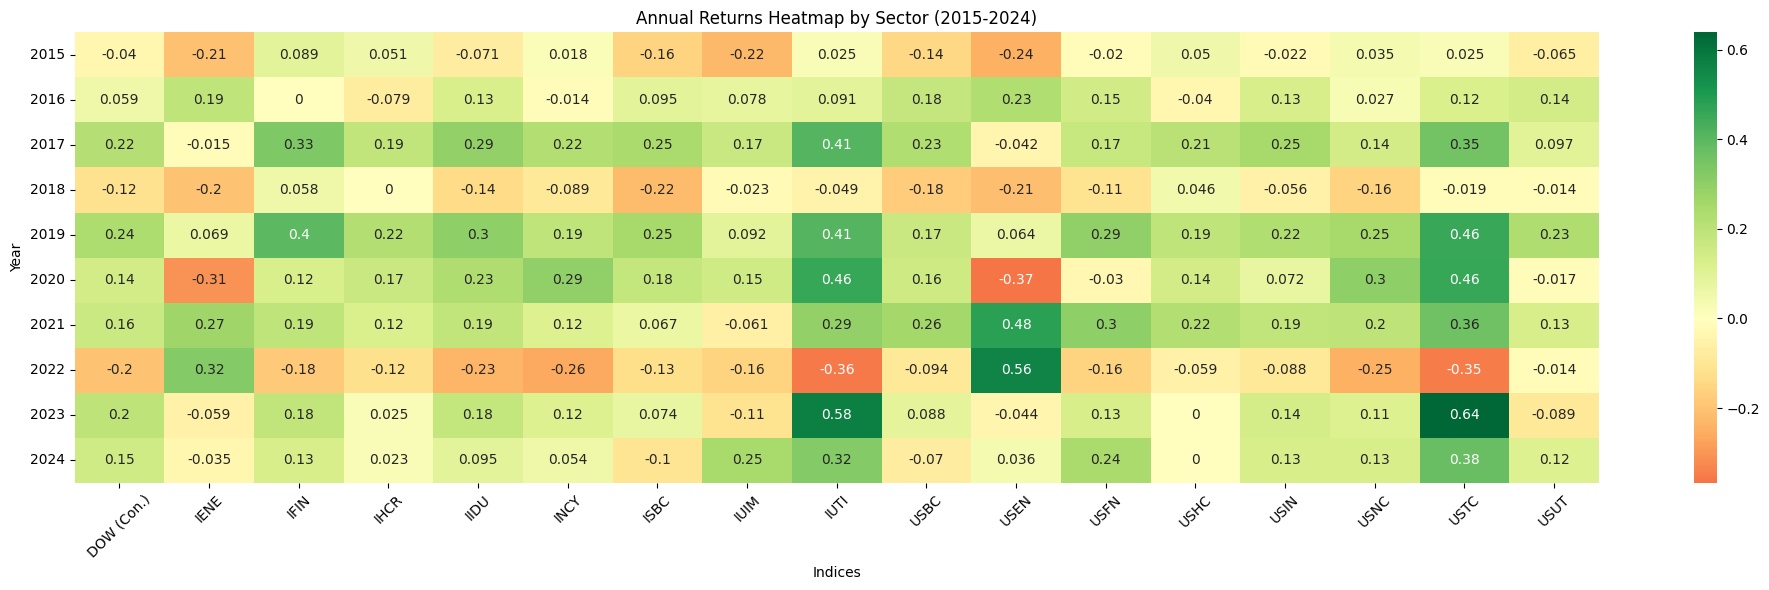

In [ ]:
plot_annual_returns_heatmap(sector_ann_return)

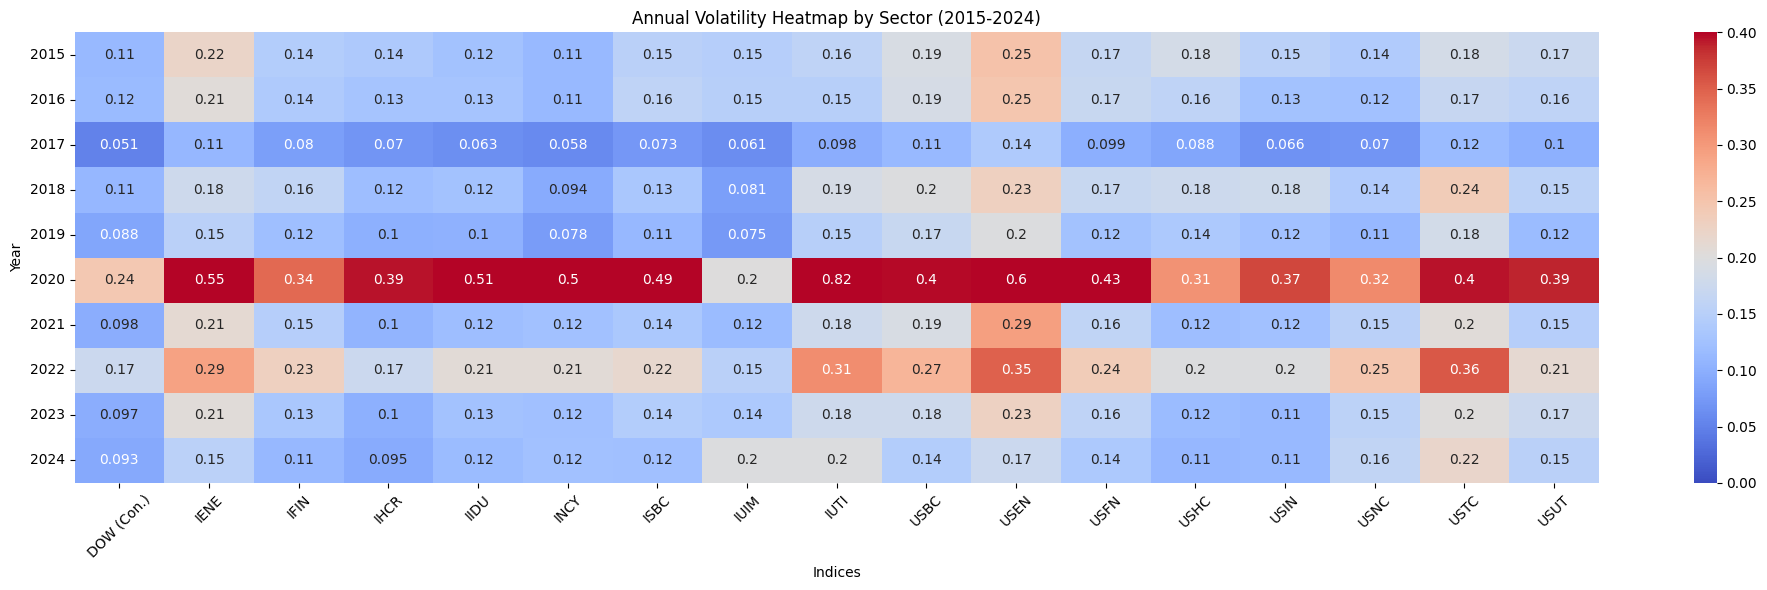

In [ ]:
plot_annual_vol_heatmap(sector_ann_vol)

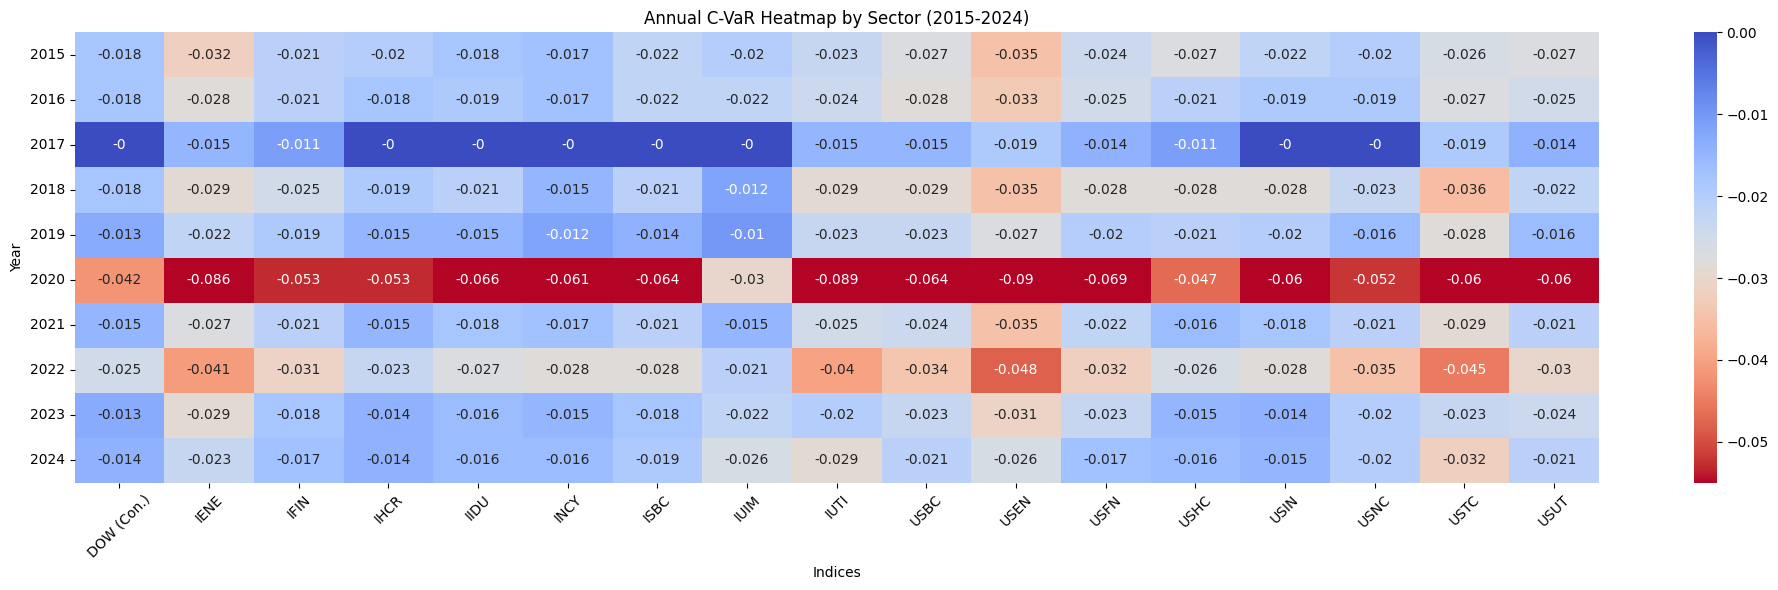

In [ ]:
plot_annual_cvar_heatmap(sector_ann_cvar)

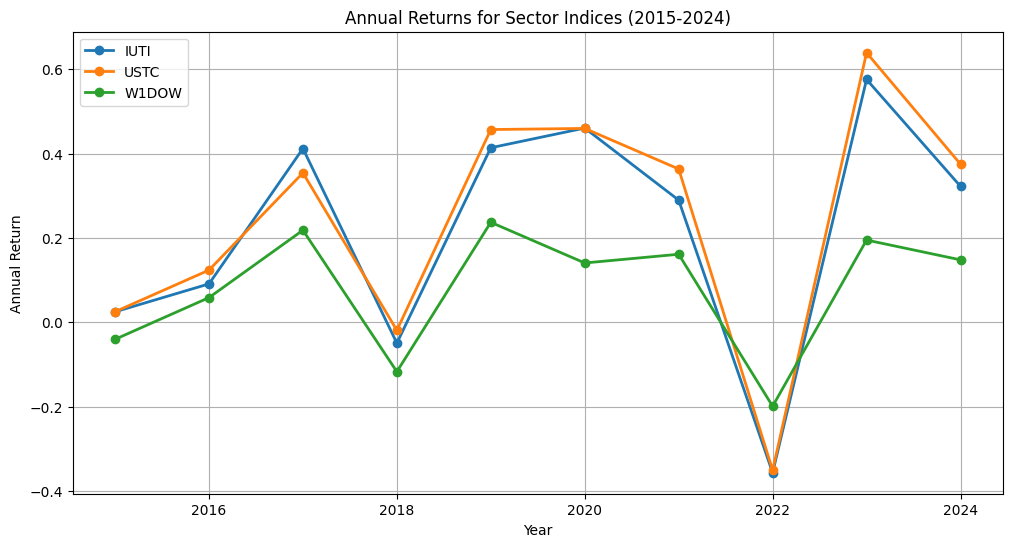

In [ ]:
# Convert the dictionary to a DataFrame
years = list(range(2015, 2025))
annual_returns_df = pd.DataFrame(annual_returns, index=years)

# Select only the sector indices
sector_indices = ["IUTI", "USTC", "W1DOW"]
annual_returns_df = annual_returns_df[sector_indices]

# Plotting the line chart
plt.figure(figsize=(12, 6))

for sector in sector_indices:
  plt.plot(years, annual_returns_df[sector], label=sector, marker="o", linewidth=2)

# Customize plot
plt.title("Annual Returns for Sector Indices (2015-2024)")
plt.xlabel("Year")
plt.ylabel("Annual Return")
plt.legend()
plt.grid(True)
plt.show()

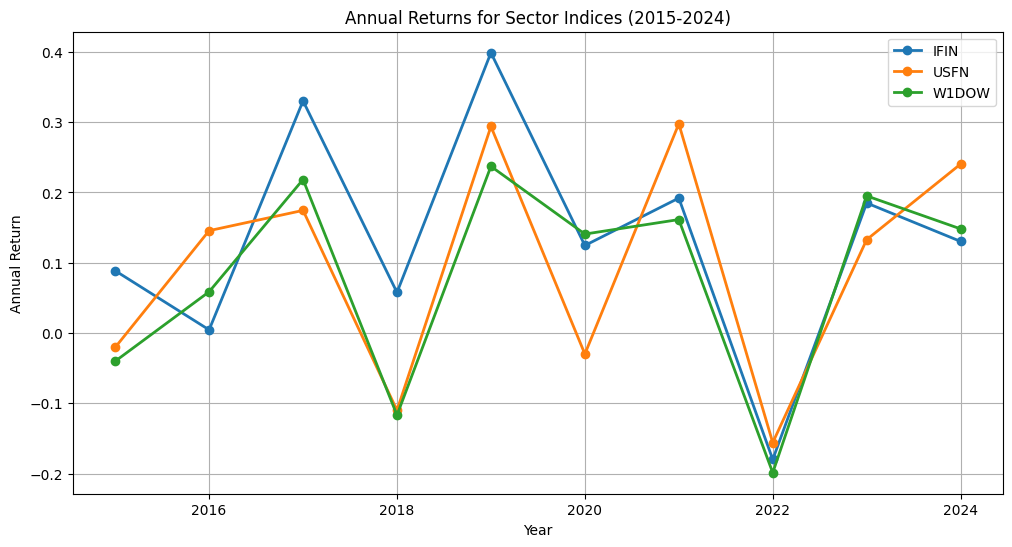

In [ ]:
# Convert the dictionary to a DataFrame
years = list(range(2015, 2025))
annual_returns_df = pd.DataFrame(annual_returns, index=years)

# Select only the sector indices
sector_indices = ["IFIN", "USFN", "W1DOW"]
annual_returns_df = annual_returns_df[sector_indices]

# Plotting the line chart
plt.figure(figsize=(12, 6))

for sector in sector_indices:
    plt.plot(years, annual_returns_df[sector], label=sector, marker="o", linewidth=2)

# Customize plot
plt.title("Annual Returns for Sector Indices (2015-2024)")
plt.xlabel("Year")
plt.ylabel("Annual Return")
plt.legend()
plt.grid(True)
plt.show()

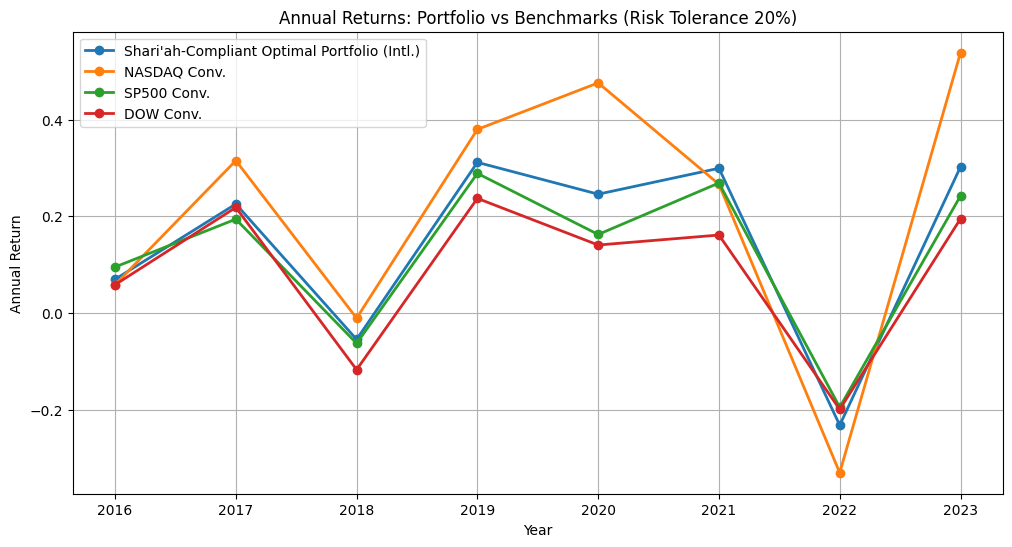

In [ ]:
portfolio_weights = np.array(weights)

# Ensure portfolio weights and indices match
indices = [
    "BDDSESD", "DJIAP", "DJICHK", "DJIM", "DSES", "DWDEURS",
    "GS100", "IMUS", "IMXLD", "JKIID", "JPNU", "SHX",
    "SWDPAC", "SWDPACXJ", "SWDXUS", "SWPXJAN", "WALLE", "WORLDS"
]

# Normalize weights if needed
portfolio_weights /= portfolio_weights.sum()

# Calculate annual returns for portfolio
portfolio_annual_returns = []
for year_index in range(len(years)):
    weighted_return = sum(
        portfolio_weights[i] * annual_returns_data[indices[i]][year_index] for i in range(len(indices))
    )
    portfolio_annual_returns.append(weighted_return)

# Extract benchmark returns
ndx_returns = annual_returns_data["NDX (Conv.)"]
spx_returns = annual_returns_data["SPX (Conv.)"]
w1dow_returns = annual_returns_data["W1DOW (Conv.)"]

# Plotting
plt.figure(figsize=(12, 6))

# Portfolio
plt.plot(years, portfolio_annual_returns, label="Shari'ah-Compliant Optimal Portfolio (Intl.)", marker="o", linewidth=2)
# Benchmarks
plt.plot(years, ndx_returns, label="NASDAQ Conv.", marker="o", linewidth=2)
plt.plot(years, spx_returns, label="SP500 Conv.", marker="o", linewidth=2)
plt.plot(years, w1dow_returns, label="DOW Conv.", marker="o", linewidth=2)

# Customize plot
plt.title("Annual Returns: Portfolio vs Benchmarks (Risk Tolerance 20%)")
plt.xlabel("Year")
plt.ylabel("Annual Return")
plt.legend()
plt.grid(True)
plt.show()

# **Diagrams**

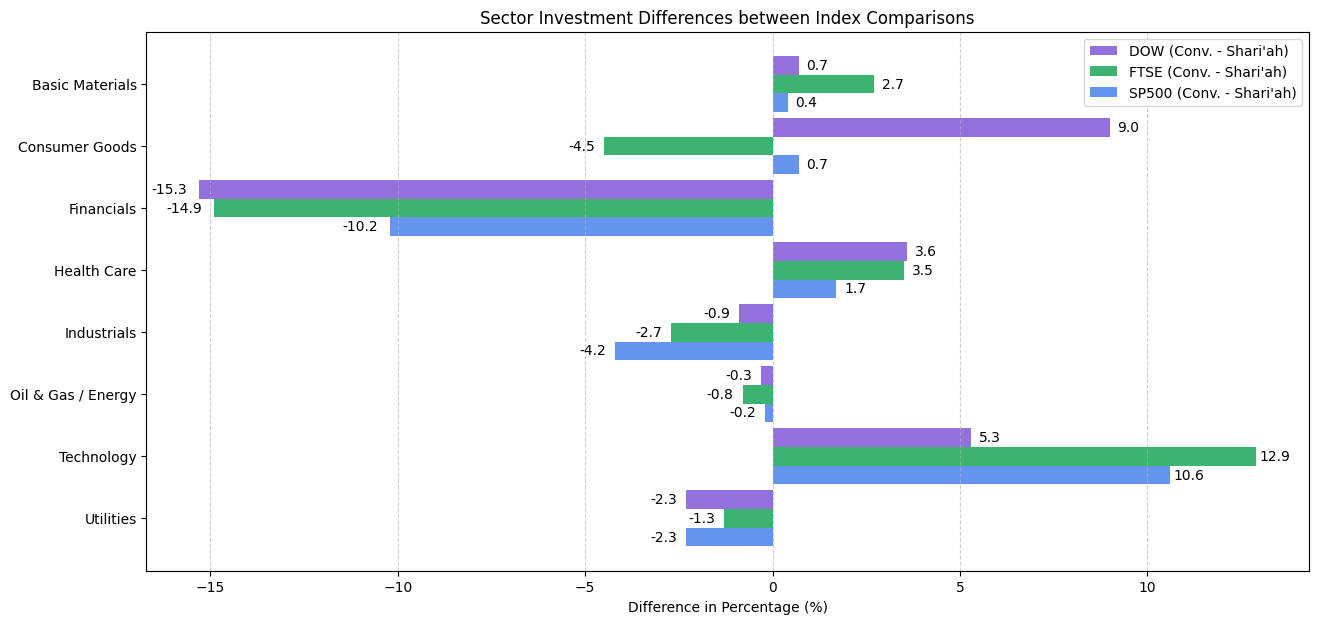

In [ ]:
# Data from the updated table
sectors = ["Basic Materials", "Consumer Goods", "Financials", "Health Care", "Industrials",
           "Oil & Gas / Energy", "Technology", "Utilities"]

# Corrected values by flipping the signs (multiplying by -1)
w1dow_djim = [(3.5 - 4.2), (10.7 - 19.7), (19.1 - 3.8), (9.7 - 13.3),
              (13.7 - 12.8), (3.9 - 3.6), (36.8 - 42.1), (2.7 - 0.4)]
ftse_worlds = [(2.9 - 5.6), (17.6 - 13.1), (15.3 - 0.4), (9.8 - 13.3),
               (13.1 - 10.4), (3.1 - 2.3), (32.0 - 44.9), (2.9 - 1.6)]
spx_shx = [(2.1 - 2.5), (16.4 - 17.1), (13.9 - 3.7), (10.6 - 12.3),
           (12.8 - 8.6), (3.4 - 3.2), (40.2 - 50.8), (2.5 - 0.2)]

# Flip the signs (correcting the mistake)
w1dow_djim = [-x for x in w1dow_djim]
ftse_worlds = [-x for x in ftse_worlds]
spx_shx = [-x for x in spx_shx]

# Bar width
bar_width = 0.3
index = np.arange(len(sectors))

# Creating the bar chart
fig, ax = plt.subplots(figsize=(15, 7))
rects1 = ax.barh(index - bar_width, w1dow_djim, bar_width, label="DOW (Conv. - Shari'ah)", color='mediumpurple')
rects2 = ax.barh(index, ftse_worlds, bar_width, label="FTSE (Conv. - Shari'ah)", color='mediumseagreen')
rects3 = ax.barh(index + bar_width, spx_shx, bar_width, label="SP500 (Conv. - Shari'ah)", color='cornflowerblue')

# Function to add labels with optimized spacing
def add_labels(rects):
    for rect in rects:
        width = rect.get_width()
        if width < -10:  # Large negative values
            offset = 0.5
        elif width < -5:  # Medium negative values
            offset = 0.5
        elif width < 0:  # Small negative values
            offset = 0.3
        else:  # Positive values
            offset = 0.5

        ax.text(width + offset if width > 0 else width - offset - 0.3,  # Adjusted for negative values
                rect.get_y() + rect.get_height()/2,
                f'{width:.1f}',
                ha='center', va='center', fontsize=10, color='black')

# Adding labels to each bar
add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

# Labels and title
ax.set_xlabel("Difference in Percentage (%)")
ax.set_title("Sector Investment Differences between Index Comparisons")
ax.set_yticks(index)
ax.set_yticklabels(sectors)
ax.legend()

# Show plot with inverted y-axis for a cleaner look
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()